# Cross-Selling of Credit Cards
**Author**: Nils Fahrni

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns

plt.style.use('ggplot')

pio.templates.default = 'ggplot2'
pd.set_option('display.max_columns', None)

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

np.random.seed(1337)

sys.path.append(parent_dir)

## Data Overview

![Entity Relationship Diagram](images/diagram.png)

## Data Preprocessing

### Data Loading

In [2]:
from src.data_utils import DataLoader

data_loader = DataLoader(base_path='data', translations_name='translation_mappings.json')
data_loader.list_datasets()

,Dataset,Number of Rows
0,loan,682
1,client,5369
2,district,77
3,trans,1056320
4,account,4500
5,card,892
6,order,6471
7,disp,5369


#### Account

In [3]:
account = data_loader.load_csv('account', parse_dates={'date': '%y%m%d'})
account.sample(5)

Mapped frequency:
{
    "POPLATEK MESICNE": "MONTHLY CHARGES",
    "POPLATEK TYDNE": "WEEKLY CHARGES",
    "POPLATEK PO OBRATU": "TRANSACTION CHARGES"
}


,account_id,district_id,frequency,date
2103,3646,63,WEEKLY CHARGES,1995-10-20
1721,981,66,MONTHLY CHARGES,1995-03-25
1193,2501,30,MONTHLY CHARGES,1994-02-26
2892,2604,68,MONTHLY CHARGES,1996-07-04
252,1189,59,MONTHLY CHARGES,1993-03-19


#### Client

In [4]:
client = data_loader.load_csv('client')

client = client.assign(gender=client['birth_number'].apply(lambda x: 'FEMALE' if int(str(x)[2:4]) > 50 else 'MALE'))

client = client.assign(birth_number=client.apply(lambda x: x['birth_number'] - 5000 if x['gender'] == 'FEMALE' else x['birth_number'], axis=1))

client['birth_number'] = pd.to_datetime(client['birth_number'], format='%y%m%d')
client['birth_date'] = client['birth_number'].apply(lambda x: x - pd.DateOffset(years=100) if x.year > 1999 else x)
client.drop('birth_number', axis=1, inplace=True)

client['age'] = (pd.to_datetime('1999-12-31') - client['birth_date']).dt.days // 365

client.sample(5)

,client_id,district_id,gender,birth_date,age
4105,4336,19,FEMALE,1969-08-02,30
2112,2229,68,MALE,1944-09-07,55
1463,1547,28,FEMALE,1927-12-20,72
3951,4177,34,MALE,1935-12-25,64
3835,4052,74,FEMALE,1950-10-17,49


#### Disposition

Removing disponents as the goal is to only advertise to owners. Disponents may be secondary users that have been authorized to use an account. They may be allowed to execute transactions on that account but they are not the authorized owners.

In [5]:
disp = data_loader.load_csv('disp')

disp = disp[disp['type'] != 'DISPONENT']

disp.drop('type', axis=1, inplace=True)

disp.sample(5)

,disp_id,client_id,account_id
4478,4737,4737,3928
5044,9512,9820,7944
3781,3994,3994,3302
1450,1531,1531,1269
1439,1520,1520,1259


#### Permanent Order

In [6]:
order = data_loader.load_csv('order')

order.sample(5)

Mapped k_symbol:
{
    "POJISTNE": "INSURANCE PAYMENT",
    "SIPO": "HOUSEHOLD",
    "LEASING": "LEASING",
    "UVER": "LOAN PAYMENT"
}


,order_id,account_id,bank_to,account_to,amount,k_symbol
5126,35080,3854,QR,36950737,1290.0,HOUSEHOLD
2680,32349,2016,ST,81232386,157.0,INSURANCE PAYMENT
403,29843,291,YZ,27026367,12925.0,NaN
5868,40382,7437,EF,2692229,6901.0,HOUSEHOLD
5952,41067,7861,OP,58806037,400.0,NaN


**Are there Null Values?**

In [7]:
display(order.isnull().sum())

display(order[order['k_symbol'].isnull()].sample(5))

order_id         0
account_id       0
bank_to          0
account_to       0
amount           0
k_symbol      1379
dtype: int64

,order_id,account_id,bank_to,account_to,amount,k_symbol
2746,32417,2057,YZ,1773274,970.0,NaN
69,29475,48,ST,2071685,1029.0,NaN
6420,45778,11013,IJ,43103534,9499.0,NaN
1788,31375,1342,ST,45400208,1011.0,NaN
2847,32533,2139,GH,92438989,4737.0,NaN


In [8]:
order['k_symbol'] = order['k_symbol'].fillna('MISSING')

order_pivot = order.pivot_table(index='account_id', columns='k_symbol', values='amount', aggfunc='count', fill_value=0)

order_pivot.sample(5)

k_symbol,HOUSEHOLD,INSURANCE PAYMENT,LEASING,LOAN PAYMENT,MISSING
account_id,,,,,
552,1,0,0,0,0
198,2,0,0,0,0
578,1,1,0,0,2
1583,0,0,0,1,0
226,1,0,0,1,0


#### Transaction

TODO: 
- amount to negative or positive based on if withdrawal or deposit
- Research account number 19 (time series account balance, at least per month)
    - this acc is volatile
    - account's balance goes negative sometimes
- what happens to accounts with multiple transactions on a day?
    - how to obtain the actual end of day balance?
        - add up withdrawals with deposits and add to balance of day before 
        - try to vectorize this problem (R antijoin mentioned)

In [9]:
transaction = data_loader.load_csv('trans', parse_dates={'date': '%y%m%d'})

transaction.sample(5)

Mapped type:
{
    "PRIJEM": "CREDIT",
    "VYDAJ": "WITHDRAWAL"
}
Mapped operation:
{
    "VYBER KARTOU": "CREDIT CARD WITHDRAWAL",
    "VKLAD": "CREDIT IN CASH",
    "PREVOD Z UCTU": "COLLECTION FROM ANOTHER BANK",
    "VYBER": "WITHDRAWAL IN CASH",
    "PREVOD NA UCET": "REMITTANCE TO ANOTHER BANK"
}
Mapped k_symbol:
{
    "POJISTNE": "INSURANCE PAYMENT",
    "SLUZBY": "PAYMENT FOR STATEMENT",
    "UROK": "INTEREST CREDITED",
    "SANKC. UROK": "SANCTION INTEREST IF NEGATIVE BALANCE",
    "SIPO": "HOUSEHOLD",
    "DUCHOD": "OLD-AGE PENSION",
    "UVER": "LOAN PAYMENT"
}


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
926595,3444421,3223,1998-07-31,CREDIT,NaN,92.9,14640.3,INTEREST CREDITED,NaN,NaN
715788,134286,450,1997-12-12,CREDIT,COLLECTION FROM ANOTHER BANK,4393.0,16076.3,OLD-AGE PENSION,AB,94329887.0
673209,3564940,1046,1997-10-31,CREDIT,NaN,130.1,27631.5,INTEREST CREDITED,NaN,NaN
776368,204567,694,1998-01-31,WITHDRAWAL,WITHDRAWAL IN CASH,14.6,29151.1,PAYMENT FOR STATEMENT,NaN,NaN
1028116,3600996,2141,1998-11-30,CREDIT,NaN,283.4,70926.4,INTEREST CREDITED,NaN,NaN


#### Loan

In [10]:
loan = data_loader.load_csv('loan', parse_dates={'date': '%y%m%d'})

loan.sample(5)

Mapped status:
{
    "A": "contract finished, no problems",
    "B": "contract finished, loan not payed",
    "C": "running contract, OK so far",
    "D": "running contract, client in debt"
}


,loan_id,account_id,date,amount,duration,payments,status
629,5015,226,1998-07-12,109344,12,9112.0,"running contract, OK so far"
323,6818,9030,1996-12-12,155616,48,3242.0,"running contract, OK so far"
670,6168,5698,1998-11-21,99216,36,2756.0,"running contract, OK so far"
407,6278,6265,1997-06-10,87360,24,3640.0,"running contract, OK so far"
27,5189,1166,1994-02-07,149040,48,3105.0,"contract finished, no problems"


**Can an account have multiple loans?**

In [11]:
print(f'Are there accounts with multiple loans: {loan["account_id"].nunique() < loan.shape[0]}')

Are there accounts with multiple loans: False


#### Credit Card

In [12]:
card = data_loader.load_csv('card', parse_dates={'issued': '%y%m%d'})

card.sample(5)

,card_id,disp_id,type,issued
159,854,6753,classic,1996-10-07
205,137,786,junior,1997-01-10
445,481,3102,junior,1998-01-06
350,19,130,classic,1997-09-09
533,510,3256,classic,1998-04-13


#### District

In [13]:
district = data_loader.load_csv('district')

district = district.rename(columns={
    'A1': 'district_id',
    'A2': 'district_name',
    'A3': 'region',
    'A4': 'population',
    'A5': 'n_municipalities_with_inhabitants_lt_499',
    'A6': 'n_municipalities_with_inhabitants_500_to_1999',
    'A7': 'n_municipalities_with_inhabitants_2000_to_9999',
    'A8': 'n_municipalities_with_inhabitants_gt_10000',
    'A9': 'n_cities',
    'A10': 'ratio_urban_inhabitants',
    'A11': 'average_salary',
    'A12': 'unemployment_rate_95',
    'A13': 'unemployment_rate_96',
    'A14': 'enterpreneurs_per_1000_inhabitants',
    'A15': 'n_commited_crimes_95',
    'A16': 'n_commited_crimes_96'
})

district.sample(5)

,district_id,district_name,region,population,n_municipalities_with_inhabitants_lt_499,n_municipalities_with_inhabitants_500_to_1999,n_municipalities_with_inhabitants_2000_to_9999,n_municipalities_with_inhabitants_gt_10000,n_cities,ratio_urban_inhabitants,average_salary,unemployment_rate_95,unemployment_rate_96,enterpreneurs_per_1000_inhabitants,n_commited_crimes_95,n_commited_crimes_96
70,71,Novy Jicin,north Moravia,161227,5,35,11,4,10,69.7,8678,5.93,5.57,102,4980,4595
72,73,Opava,north Moravia,182027,17,49,12,2,7,56.4,8746,3.33,3.74,90,4355,4433
75,76,Sumperk,north Moravia,127369,31,32,13,2,7,51.2,8369,4.73,5.88,107,3736,2807
25,26,Plzen - mesto,west Bohemia,170449,0,0,0,1,1,100.0,10787,2.64,3.09,131,6041,6261
55,56,Breclav,south Moravia,124605,11,42,14,1,8,46.0,8772,4.69,4.98,126,2854,3158


### Data Merging

In [14]:
from src.data_utils import add_prefix_except_id

account = add_prefix_except_id(account, 'account_', id_exceptions=['district_id'])
client_df = disp.merge(account, on='account_id', how='left')

client = add_prefix_except_id(client, 'client_', id_exceptions=['district_id'])
client_df = client_df.merge(client, on='client_id', how='left')

order = add_prefix_except_id(order_pivot, 'ordertype_')
client_df = client_df.merge(order, on='account_id', how='left')

loan = add_prefix_except_id(loan, 'loan_')
client_df = client_df.merge(loan, on='account_id', how='left')

card = add_prefix_except_id(card, 'card_')
client_df = client_df.merge(card, on='disp_id', how='left')

client_district = add_prefix_except_id(district, 'client_district_')
client_df = client_df.merge(client_district, left_on='client_district_id', right_on='district_id', how='left')

account_district = add_prefix_except_id(district, 'account_district_')
client_df = client_df.merge(account_district, left_on='account_district_id', right_on='district_id', how='left')

client_df.sample(5)

n_merged_base_client = client_df.shape[0]

In [15]:
assert client_df['account_id'].nunique() == client_df.shape[0]

### Data Cleaning

#### Removing Junior Cards

In [16]:
junior_clients = client_df[client_df['card_type'] == 'junior']

client_df = client_df[~client_df['account_id'].isin(junior_clients['account_id'])]

transaction = transaction[~transaction['account_id'].isin(junior_clients['account_id'])]

client_df['has_card'] = client_df['card_id'].notnull()

print(f'Number of junior clients: {junior_clients.shape[0]}')
print(f'Number of clients remaining: {client_df.shape[0]}')

Number of junior clients: 145
Number of clients remaining: 4355


Additionally, clients without cards could potentially be in the age range of someone who would naturally get a Junior Card. Since there is no information on how these special cases should be handled, the clients in that age bracket will be removed in the following step.

To find out what clients should get removed from the dataset, firts the age distribution needs to be examined to find a suitable "cutoff age".

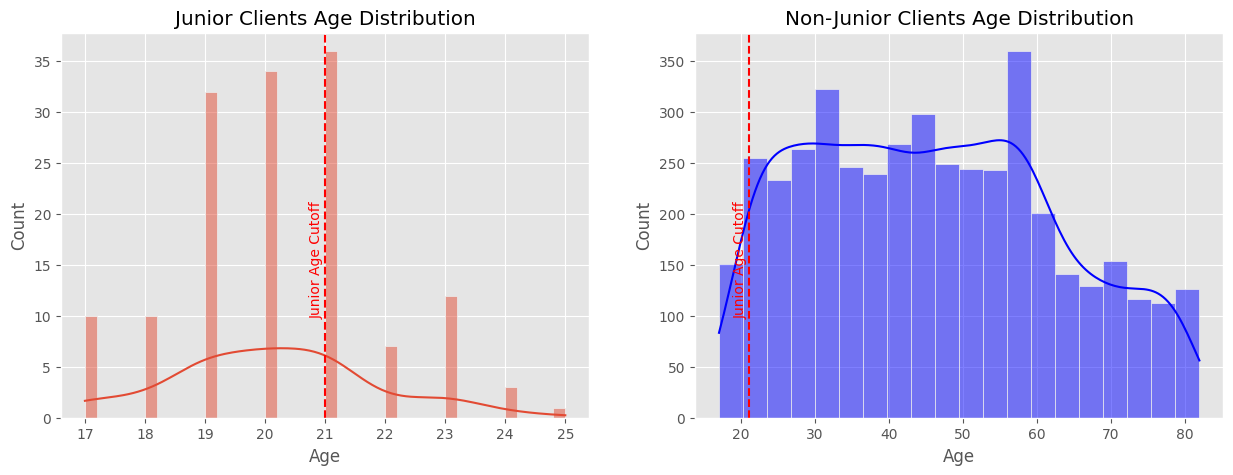

In [17]:
JUNIOR_AGE_CUTOFF = 21

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(junior_clients['client_age'], bins=40, ax=ax[0], kde=True)
ax[0].axvline(JUNIOR_AGE_CUTOFF, color='r', linestyle='--')
ax[0].text(JUNIOR_AGE_CUTOFF - .25, 10, 'Junior Age Cutoff', rotation=90, color='r')
ax[0].set_title('Junior Clients Age Distribution')
ax[0].set_xlabel('Age')

sns.histplot(client_df['client_age'], bins=20, ax=ax[1], color='b', kde=True)
ax[1].axvline(JUNIOR_AGE_CUTOFF, color='r', linestyle='--')
ax[1].text(JUNIOR_AGE_CUTOFF - 2, 100, 'Junior Age Cutoff', rotation=90, color='r')
ax[1].set_title('Non-Junior Clients Age Distribution')
ax[1].set_xlabel('Age')

plt.show()

For the cutoff the age 21 was chosen (meaning non-card-holders that are younger than the threshold or exactly at the threshold) since we can see a rapid decrease in Junior Card Holders after the proposed age. These remaining customers above the cutoff age that still own a Junior card could just remain there due to the reason that the bank may need some time to reissue regular cards; Which is why no clear cutoff age can be found in the distribution.

In [18]:
underage_clients = client_df[(client_df['client_age'] <= JUNIOR_AGE_CUTOFF) & (~client_df['has_card'])]

client_df = client_df[~client_df['client_id'].isin(underage_clients['client_id'])]
transaction = transaction[~transaction['account_id'].isin(underage_clients['account_id'])]

print(f'Number of underage clients: {underage_clients.shape[0]}')
print(f'Number of clients remaining after underage client removal: {client_df.shape[0]}')

Number of underage clients: 222
Number of clients remaining after underage client removal: 4133


## Model Construction

### Processing Transactional Data
- The goal is to predict if a non-card-owner will buy a card or not

The first task is to look if every account in the transactions dataframe has a "first transaction". This would make the calculation of the monthly balance much easier since everything can be summed up without having to worry that there were months without records in the transaction dataframe.

In [19]:
# Find the minimum (first) transaction(s) date for each account
min_dates = transaction.groupby('account_id')['date'].min().reset_index()
min_dates.rename(columns={'date': 'min_date'}, inplace=True)

# Merge the minimum date back to the transactions to identify all transactions on the first day
transactions_with_min_date = pd.merge(transaction, min_dates, on='account_id')

# Filter transactions that are on the first day
first_day_transactions = transactions_with_min_date[transactions_with_min_date['date'] == transactions_with_min_date['min_date']]
first_day_transactions = first_day_transactions.copy()

# Now, for each of these first day transactions, check if any have amount equals balance
first_day_transactions['amount_equals_balance'] = first_day_transactions['amount'] == first_day_transactions['balance']

# Group by account_id and check if any transactions for each account meet the condition
accounts_meeting_condition = first_day_transactions.groupby('account_id')['amount_equals_balance'].any().reset_index()

# Verify if all accounts have at least one transaction on the first day meeting the condition
all_accounts_covered = accounts_meeting_condition['amount_equals_balance'].all()

print("Does every account's first day of transactions include at least one transaction where amount equals balance?", all_accounts_covered)

Does every account's first day of transactions include at least one transaction where amount equals balance? True


Now every accounts balance needs to be calculated per month.

In [20]:
transaction['month'] = transaction['date'].dt.to_period('M')

transactions_monthly = transaction.groupby(['account_id', 'month']).agg(
    volume=('amount', 'sum'),
    credit=('amount', lambda x: x[x > 0].sum()),
    withdrawal=('amount', lambda x: x[x < 0].sum()),
    n_transactions=('amount', 'size')
).reset_index()

In [21]:
transactions_monthly['month'] = pd.PeriodIndex(transactions_monthly['month'])

date_ranges = transactions_monthly.groupby('account_id')['month'].agg(['min', 'max'])

def reindex_df(group, account_id):
    idx = pd.period_range(start=group['month'].min(), end=group['month'].max(), freq='M')
    group.set_index('month', inplace=True)
    group = group.reindex(idx, fill_value=0)
    group.reset_index(inplace=True)
    group.rename(columns={'index': 'month'}, inplace=True)
    group['account_id'] = account_id
    return group

transactions_monthly = (transactions_monthly.groupby('account_id')
                        .apply(lambda x: reindex_df(x, x.name))
                        .reset_index(level=0, drop=True))

# Calculate cumulative balance
transactions_monthly['balance'] = transactions_monthly.groupby('account_id')['volume'].cumsum()

In [22]:
transactions_monthly

,month,account_id,volume,credit,withdrawal,n_transactions,balance
0,1995-03,1,1000.0,1000.0,0.0,1,1000.0
1,1995-04,1,16298.2,16298.2,0.0,3,17298.2
2,1995-05,1,5858.0,5858.0,0.0,3,23156.2
3,1995-06,1,3979.6,3979.6,0.0,3,27135.8
4,1995-07,1,9087.9,9087.9,0.0,3,36223.7
...,...,...,...,...,...,...,...
36,1998-08,11382,54569.5,54569.5,0.0,7,2386853.6
37,1998-09,11382,44120.0,44120.0,0.0,5,2430973.6
38,1998-10,11382,63262.2,63262.2,0.0,6,2494235.8
39,1998-11,11382,50165.7,50165.7,0.0,5,2544401.5


### Defining Roll-Up Windows of Transactions

Before we can continue to filter out customers that have at least 13 Months of transaction history it is also needed to give non-customers a fictional `card_issued` date so we can build negative samples that also contain a 13-Month rollup window.

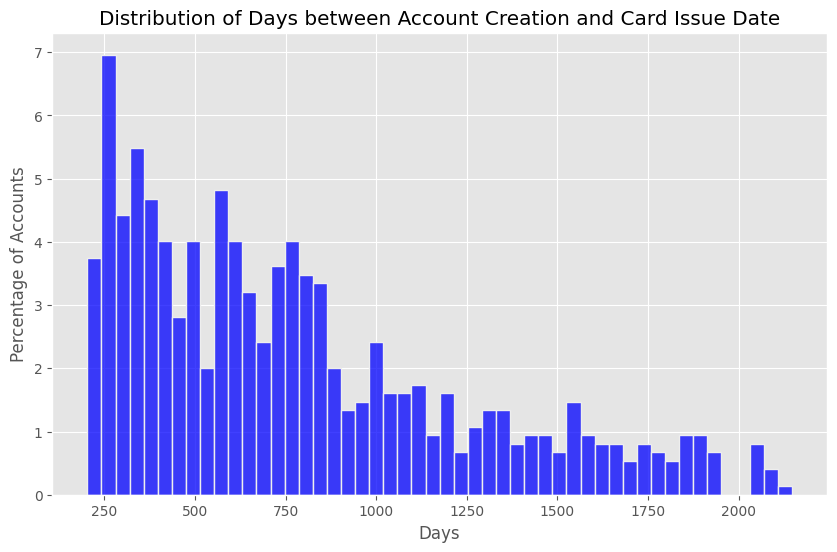

In [23]:
clients_with_cards = client_df[~client_df['card_issued'].isnull()]
time_between_creation_and_issue = (clients_with_cards['card_issued'] - clients_with_cards['account_date']).dt.days

plt.figure(figsize=(10, 6))
sns.histplot(time_between_creation_and_issue, bins=50, stat='percent', kde=False, color='blue', linewidth=1)

plt.title('Distribution of Days between Account Creation and Card Issue Date')
plt.xlabel('Days')
plt.ylabel('Percentage of Accounts')
plt.grid(True)

plt.show()

An observation we can make when looking at the distribution of when cards usually get issued after the account creation is that there don't seem to be any issuances before day 200 of the account.

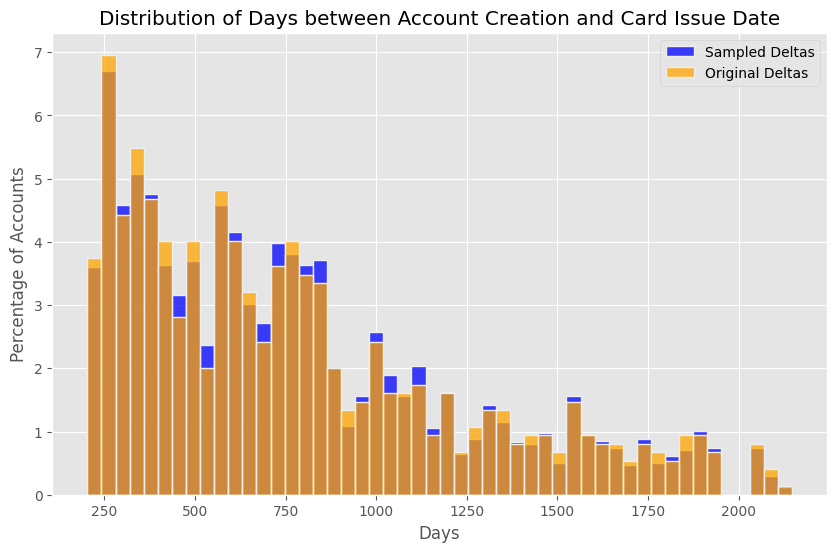

In [24]:
np.random.seed(1337)

sampled_deltas = np.random.choice(time_between_creation_and_issue, size=len(client_df[client_df['card_issued'].isnull()]))

plt.figure(figsize=(10, 6))
sns.histplot(sampled_deltas, bins=50, stat='percent', kde=False, color='blue', linewidth=1, label='Sampled Deltas')
sns.histplot(time_between_creation_and_issue, bins=50, stat='percent', kde=False, color='orange', linewidth=1, label='Original Deltas')

plt.title('Distribution of Days between Account Creation and Card Issue Date')
plt.xlabel('Days')
plt.ylabel('Percentage of Accounts')
plt.legend()
plt.grid(True)

plt.show()

In [25]:
if len(client_df[client_df['card_issued'].isnull()]) > 0:
    client_df.loc[client_df['card_issued'].isnull(), 'card_issued'] = client_df.loc[client_df['card_issued'].isnull(), 'account_date'] + pd.to_timedelta(sampled_deltas, unit='D')
    
print(f'Number of NaT/NaN values in card_issued: {client_df["card_issued"].isnull().sum()}')

Number of NaT/NaN values in card_issued: 0


In [26]:
card_issued = card.groupby('disp_id')['card_issued'].min().reset_index()
card_issued.head(5)

,disp_id,card_issued
0,9,1998-10-16
1,19,1998-03-13
2,41,1995-09-03
3,42,1998-11-26
4,51,1995-04-24


In [27]:
client_df[client_df['disp_id'].isnull()].shape[0]

transactions_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169783 entries, 0 to 40
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype    
---  ------          --------------   -----    
 0   month           169783 non-null  period[M]
 1   account_id      169783 non-null  int64    
 2   volume          169783 non-null  float64  
 3   credit          169783 non-null  float64  
 4   withdrawal      169783 non-null  float64  
 5   n_transactions  169783 non-null  int64    
 6   balance         169783 non-null  float64  
dtypes: float64(4), int64(2), period[M](1)
memory usage: 10.4 MB


In [28]:
transactions_monthly = transactions_monthly.merge(client_df[['account_id', 'card_issued']], left_on='account_id', right_on='account_id', how='left')

transactions_monthly.head()

,month,account_id,volume,credit,withdrawal,n_transactions,balance,card_issued
0,1995-03,1,1000.0,1000.0,0.0,1,1000.0,1998-09-18
1,1995-04,1,16298.2,16298.2,0.0,3,17298.2,1998-09-18
2,1995-05,1,5858.0,5858.0,0.0,3,23156.2,1998-09-18
3,1995-06,1,3979.6,3979.6,0.0,3,27135.8,1998-09-18
4,1995-07,1,9087.9,9087.9,0.0,3,36223.7,1998-09-18


Now, let's see if the join worked correctly and we don't have any transactions without a `card_issued` date anymore.

In [29]:
assert transactions_monthly['card_issued'].isnull().sum() == 0

### Validating Negative Examples
The goal for our model will be to be able to learn from a base set of customers (with and without cards) that lived through the same economic circumstances. To validate that all customers in our current set are represented in a well distributed way, this next plot looks at the distribution of volume throughout the datasets timeframe.

In [30]:
transactions_monthly['has_card'] = transactions_monthly['account_id'].isin(client_df[client_df['has_card']]['account_id'])

In [31]:
transactions_monthly.reset_index(inplace=True)
transactions_monthly['id'] = range(len(transactions_monthly))
transactions_monthly.set_index('id', inplace=True)

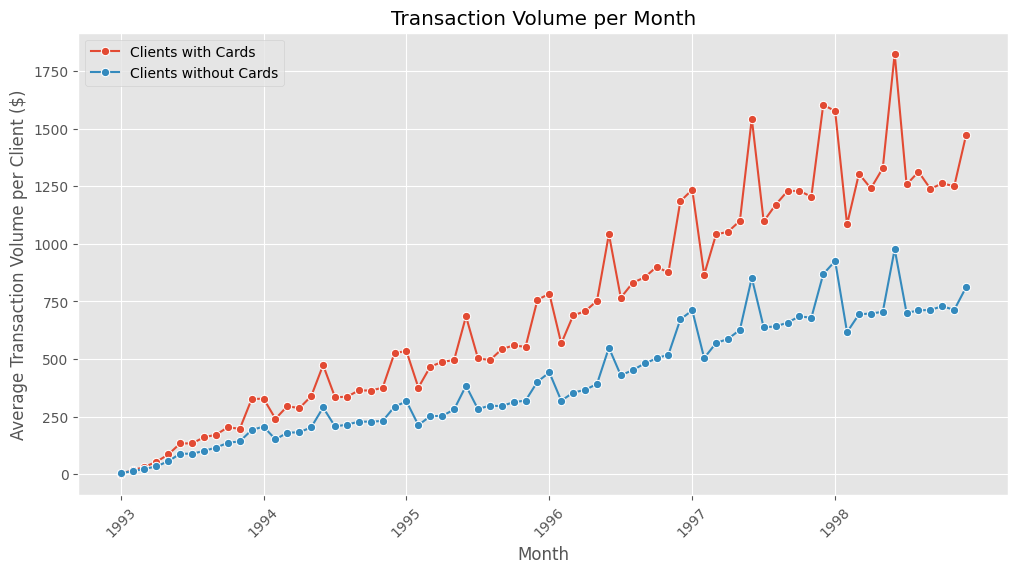

In [32]:
transactions_with_cards = transactions_monthly[transactions_monthly['has_card'] == True]
transactions_without_cards = transactions_monthly[transactions_monthly['has_card'] == False]

grouped_with_cards = transactions_with_cards.groupby('month')['volume'].sum().reset_index()
grouped_without_cards = transactions_without_cards.groupby('month')['volume'].sum().reset_index()

grouped_with_cards['month'] = grouped_with_cards['month'].astype(str)
grouped_without_cards['month'] = grouped_without_cards['month'].astype(str)

grouped_with_cards['avg_volume_per_client'] = grouped_with_cards['volume'] / transactions_with_cards.shape[0]
grouped_without_cards['avg_volume_per_client'] = grouped_without_cards['volume'] / transactions_without_cards.shape[0]

plt.figure(figsize=(12, 6))

sns.lineplot(x='month', y='avg_volume_per_client', data=grouped_with_cards, marker='o', label='Clients with Cards')
sns.lineplot(x='month', y='avg_volume_per_client', data=grouped_without_cards, marker='o', label='Clients without Cards')

plt.title('Transaction Volume per Month')
plt.xlabel('Month')
plt.ylabel('Average Transaction Volume per Client ($)')
plt.legend()
plt.grid(True)

plt.xticks(ticks=grouped_with_cards['month'][grouped_with_cards['month'].str.endswith('-01')], rotation=45)
plt.gca().set_xticklabels([label[:4] for label in grouped_with_cards['month'][grouped_with_cards['month'].str.endswith('-01')]])

plt.show()


In [33]:
transactions_monthly['card_issued'] = pd.to_datetime(transactions_monthly['card_issued'])
transactions_monthly['card_issued_period'] = transactions_monthly['card_issued'].dt.to_period('M')

transactions_monthly['month_diff'] = transactions_monthly.apply(lambda row: (row['card_issued_period'] - row['month']).n if pd.notnull(row['card_issued_period']) and pd.notnull(row['month']) else None, axis=1)

filtered_transactions = transactions_monthly[transactions_monthly['month_diff'].between(1, 13)]

In [34]:
transactions_monthly

,index,month,account_id,volume,credit,withdrawal,n_transactions,balance,card_issued,has_card,card_issued_period,month_diff
id,,,,,,,,,,,,
0,0,1995-03,1,1000.0,1000.0,0.0,1,1000.0,1998-09-18,False,1998-09,42
1,1,1995-04,1,16298.2,16298.2,0.0,3,17298.2,1998-09-18,False,1998-09,41
2,2,1995-05,1,5858.0,5858.0,0.0,3,23156.2,1998-09-18,False,1998-09,40
3,3,1995-06,1,3979.6,3979.6,0.0,3,27135.8,1998-09-18,False,1998-09,39
4,4,1995-07,1,9087.9,9087.9,0.0,3,36223.7,1998-09-18,False,1998-09,38
...,...,...,...,...,...,...,...,...,...,...,...,...
169778,169778,1998-08,11382,54569.5,54569.5,0.0,7,2386853.6,1997-12-02,False,1997-12,-8
169779,169779,1998-09,11382,44120.0,44120.0,0.0,5,2430973.6,1997-12-02,False,1997-12,-9
169780,169780,1998-10,11382,63262.2,63262.2,0.0,6,2494235.8,1997-12-02,False,1997-12,-10


In [35]:
filtered_transactions.sort_values(by=['account_id', 'month_diff'])

,index,month,account_id,volume,credit,withdrawal,n_transactions,balance,card_issued,has_card,card_issued_period,month_diff
id,,,,,,,,,,,,
41,41,1998-08,1,6492.7,6492.7,0.0,5,338855.2,1998-09-18,False,1998-09,1
40,40,1998-07,1,6221.0,6221.0,0.0,4,332362.5,1998-09-18,False,1998-09,2
39,39,1998-06,1,6667.1,6667.1,0.0,5,326141.5,1998-09-18,False,1998-09,3
38,38,1998-05,1,6212.3,6212.3,0.0,4,319474.4,1998-09-18,False,1998-09,4
37,37,1998-04,1,7435.5,7435.5,0.0,6,313262.1,1998-09-18,False,1998-09,5
...,...,...,...,...,...,...,...,...,...,...,...,...
169761,169761,1997-03,11382,42447.5,42447.5,0.0,6,1251031.7,1997-12-02,False,1997-12,9
169760,169760,1997-02,11382,60560.1,60560.1,0.0,8,1208584.2,1997-12-02,False,1997-12,10
169759,169759,1997-01,11382,88536.5,88536.5,0.0,13,1148024.1,1997-12-02,False,1997-12,11


#### Pivoting the transactions

An issue at this point can be that an account may have months without any transactions, so there needs to be a more thorough process to interpolate the data:
- **Volume, Withdrawal, Credit and Number of Transactions**: If there are missing months in these variables we can just set `0` as their value as there has not been any activity if there were no recorded months.
- **Balance**: The balance will get recursively set to the last preceding recorded month. So if there are consecutive "missing" months in transactions the balance will always be set to the last recorded month.

In [36]:
account_summary = pd.DataFrame(filtered_transactions['account_id'].unique(), columns=['account_id'])

variables_to_pivot = ['volume', 'withdrawal', 'credit', 'n_transactions', 'balance']

for variable in variables_to_pivot:
    grouped = filtered_transactions.groupby(['account_id', 'month_diff'])[variable].sum().reset_index()
    pivot = grouped.pivot(index='account_id', columns='month_diff', values=variable).reset_index()
    pivot.columns = ['account_id'] + [f'{variable}_month_diff_{int(col)}' if col != 'account_id' else 'account_id' for col in pivot.columns[1:]]
    account_summary = pd.merge(account_summary, pivot, on='account_id', how='left')

for variable in ['volume', 'withdrawal', 'credit', 'n_transactions']:
    account_summary.update(account_summary.filter(regex=f'^{variable}_').fillna(0))

def find_last_balance(account_id, starting_month_diff):
    higher_month_diff = transactions_monthly[
        (transactions_monthly['account_id'] == account_id) & 
        (transactions_monthly['month_diff'] >= starting_month_diff)
    ].sort_values('month_diff')
    
    last_balance_row = higher_month_diff[higher_month_diff['balance'].notna()].head(1)
    
    if not last_balance_row.empty:
        return last_balance_row.iloc[0]['balance']
    else:
        return 0

balance_columns = [col for col in account_summary.columns if 'balance_month_diff_' in col]
for idx, row in account_summary.iterrows():
    for col in balance_columns:
        if pd.isna(row[col]):
            month_diff = int(col.split('_')[-1])
            last_balance = find_last_balance(row['account_id'], month_diff + 1)
            account_summary.at[idx, col] = last_balance

In [37]:
account_summary.head()

,account_id,volume_month_diff_1,volume_month_diff_2,volume_month_diff_3,volume_month_diff_4,volume_month_diff_5,volume_month_diff_6,volume_month_diff_7,volume_month_diff_8,volume_month_diff_9,volume_month_diff_10,volume_month_diff_11,volume_month_diff_12,volume_month_diff_13,withdrawal_month_diff_1,withdrawal_month_diff_2,withdrawal_month_diff_3,withdrawal_month_diff_4,withdrawal_month_diff_5,withdrawal_month_diff_6,withdrawal_month_diff_7,withdrawal_month_diff_8,withdrawal_month_diff_9,withdrawal_month_diff_10,withdrawal_month_diff_11,withdrawal_month_diff_12,withdrawal_month_diff_13,credit_month_diff_1,credit_month_diff_2,credit_month_diff_3,credit_month_diff_4,credit_month_diff_5,credit_month_diff_6,credit_month_diff_7,credit_month_diff_8,credit_month_diff_9,credit_month_diff_10,credit_month_diff_11,credit_month_diff_12,credit_month_diff_13,n_transactions_month_diff_1,n_transactions_month_diff_2,n_transactions_month_diff_3,n_transactions_month_diff_4,n_transactions_month_diff_5,n_transactions_month_diff_6,n_transactions_month_diff_7,n_transactions_month_diff_8,n_transactions_month_diff_9,n_transactions_month_diff_10,n_transactions_month_diff_11,n_transactions_month_diff_12,n_transactions_month_diff_13,balance_month_diff_1,balance_month_diff_2,balance_month_diff_3,balance_month_diff_4,balance_month_diff_5,balance_month_diff_6,balance_month_diff_7,balance_month_diff_8,balance_month_diff_9,balance_month_diff_10,balance_month_diff_11,balance_month_diff_12,balance_month_diff_13
0,1,6492.7,6221.0,6667.1,6212.3,7435.5,7018.6,6701.9,9091.5,10907.2,7318.0,6218.0,6600.6,8282.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6492.7,6221.0,6667.1,6212.3,7435.5,7018.6,6701.9,9091.5,10907.2,7318.0,6218.0,6600.6,8282.7,5.0,4.0,5.0,4.0,6.0,5.0,5.0,10.0,5.0,5.0,4.0,5.0,6.0,338855.2,332362.5,326141.5,319474.4,313262.1,305826.6,298808.0,292106.1,283014.6,272107.4,264789.4,258571.4,251970.8
1,2,34617.6,45943.4,52856.1,47098.6,52913.9,37980.7,31345.5,23949.5,1100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34617.6,45943.4,52856.1,47098.6,52913.9,37980.7,31345.5,23949.5,1100.0,0.0,0.0,0.0,0.0,6.0,7.0,7.0,6.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,327805.3,293187.7,247244.3,194388.2,147289.6,94375.7,56395.0,25049.5,1100.0,0.0,0.0,0.0,0.0
2,4,10917.6,12013.8,9011.7,14254.5,11343.0,9015.0,10769.2,9003.4,20249.4,13529.7,9040.6,9031.2,12329.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10917.6,12013.8,9011.7,14254.5,11343.0,9015.0,10769.2,9003.4,20249.4,13529.7,9040.6,9031.2,12329.5,6.0,6.0,5.0,6.0,7.0,5.0,6.0,5.0,12.0,7.0,5.0,5.0,6.0,195475.7,184558.1,172544.3,163532.6,149278.1,137935.1,128920.1,118150.9,109147.5,88898.1,75368.4,66327.8,57296.6
3,5,8607.1,7797.2,15720.3,10825.1,7812.5,5035.1,5017.0,5017.0,5017.0,5017.0,600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8607.1,7797.2,15720.3,10825.1,7812.5,5035.1,5017.0,5017.0,5017.0,5017.0,600.0,0.0,0.0,5.0,4.0,10.0,6.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,76465.3,67858.2,60061.0,44340.7,33515.6,25703.1,20668.0,15651.0,10634.0,5617.0,600.0,0.0,0.0
4,6,14333.0,10810.0,10798.3,11989.9,20888.8,13055.1,10807.0,13039.2,10792.4,23857.9,11865.2,10815.6,10803.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14333.0,10810.0,10798.3,11989.9,20888.8,13055.1,10807.0,13039.2,10792.4,23857.9,11865.2,10815.6,10803.9,5.0,4.0,4.0,5.0,6.0,5.0,4.0,5.0,4.0,11.0,6.0,4.0,4.0,625481.9,611148.9,600338.9,589540.6,577550.7,556661.9,543606.8,532799.8,519760.6,508968.2,485110.3,473245.1,462429.5


In [38]:
client_df = client_df.merge(account_summary, on='account_id', how='inner')

### Bringing the data together

In [39]:
n_lt_13_month_hist = transactions_monthly['account_id'].nunique()-filtered_transactions['account_id'].nunique()

preprocessing_summary = [
        n_merged_base_client,
        -len(junior_clients),
        -n_lt_13_month_hist,
        -len(underage_clients),
        len(client_df)
]

fig = go.Figure(go.Waterfall(
        name = "20", orientation = "v",
        measure = ["absolute", "relative", "relative", "relative", "total"],
        x = ["Base Client List", 
             "Junior Clients", 
             "Clients with less than 13 Months of Transaction History", 
             "Non-Card-Holders that are underage", 
             "Remaining Clients"],
        textposition = "outside",
        y = preprocessing_summary,
        text = [str(x) for x in preprocessing_summary],
        connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = "Profit and loss statement 2018",
        showlegend = True
)

fig.show()

## Exploratory Data Analysis

### Exploring Missing Values

In [40]:
missing_values = client_df.isnull().sum()

missing_values = pd.DataFrame({
    'Number of Missing Values': missing_values[missing_values > 0],
    'Percentage of Missing Values': [
        f"{x:.2f}%" for x in (missing_values[missing_values > 0] / client_df.shape[0] * 100).round(2)
    ]
}, columns=['Number of Missing Values', 'Percentage of Missing Values'])

fig = go.Figure()

fig.add_trace(go.Bar(
    x=missing_values.index,
    y=missing_values['Number of Missing Values'],
    text=missing_values['Percentage of Missing Values'],
    textposition='auto'
))

fig.update_layout(
    title='Missing Values in the Dataset',
    xaxis_title='Columns',
    yaxis_title='Number of Missing Values'
)

fig.show()

### Cardholders vs Non-Cardholders

In [41]:
card_owners = client_df[client_df['has_card']]
non_card_owners = client_df[~client_df['has_card']]

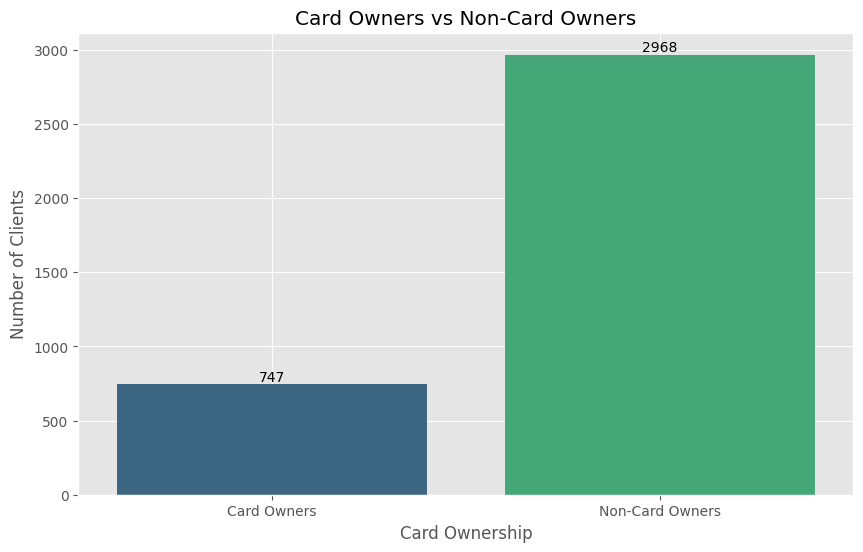

In [42]:
data = {
    'Card Ownership': ['Card Owners', 'Non-Card Owners'],
    'Number of Clients': [card_owners.shape[0], non_card_owners.shape[0]]
}

plt.figure(figsize=(10, 6))
sns.barplot(x='Card Ownership', y='Number of Clients', data=data, palette='viridis', hue='Card Ownership')

for index, value in enumerate(data['Number of Clients']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.title('Card Owners vs Non-Card Owners')
plt.xlabel('Card Ownership')
plt.ylabel('Number of Clients')
plt.grid(True)

plt.show()


###  Card Types

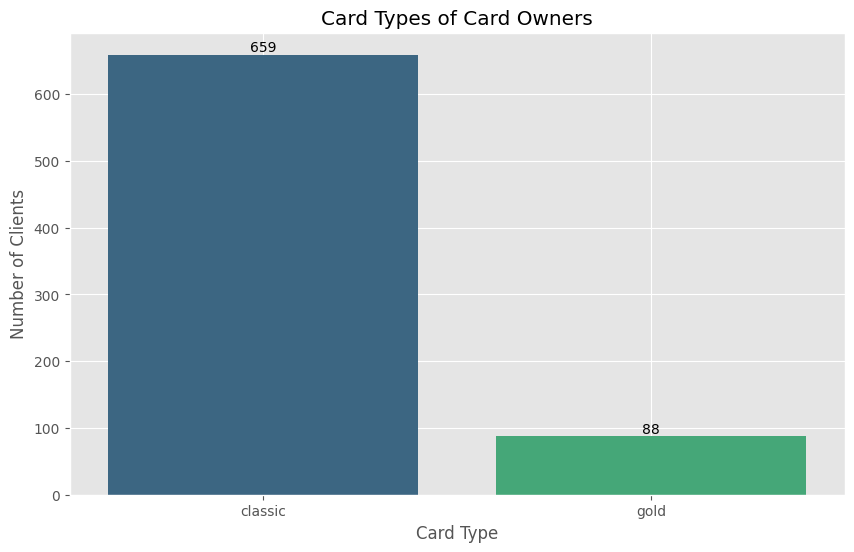

In [43]:
card_types = card_owners['card_type'].value_counts()
card_types = card_types.reset_index()
card_types.columns = ['Card Type', 'Number of Clients']

plt.figure(figsize=(10, 6))
sns.barplot(x='Card Type', y='Number of Clients', data=card_types, palette='viridis', hue='Card Type')

for index, value in enumerate(card_types['Number of Clients']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.title('Card Types of Card Owners')
plt.xlabel('Card Type')
plt.ylabel('Number of Clients')
plt.grid(True)

plt.show()

### Volume before card purchase

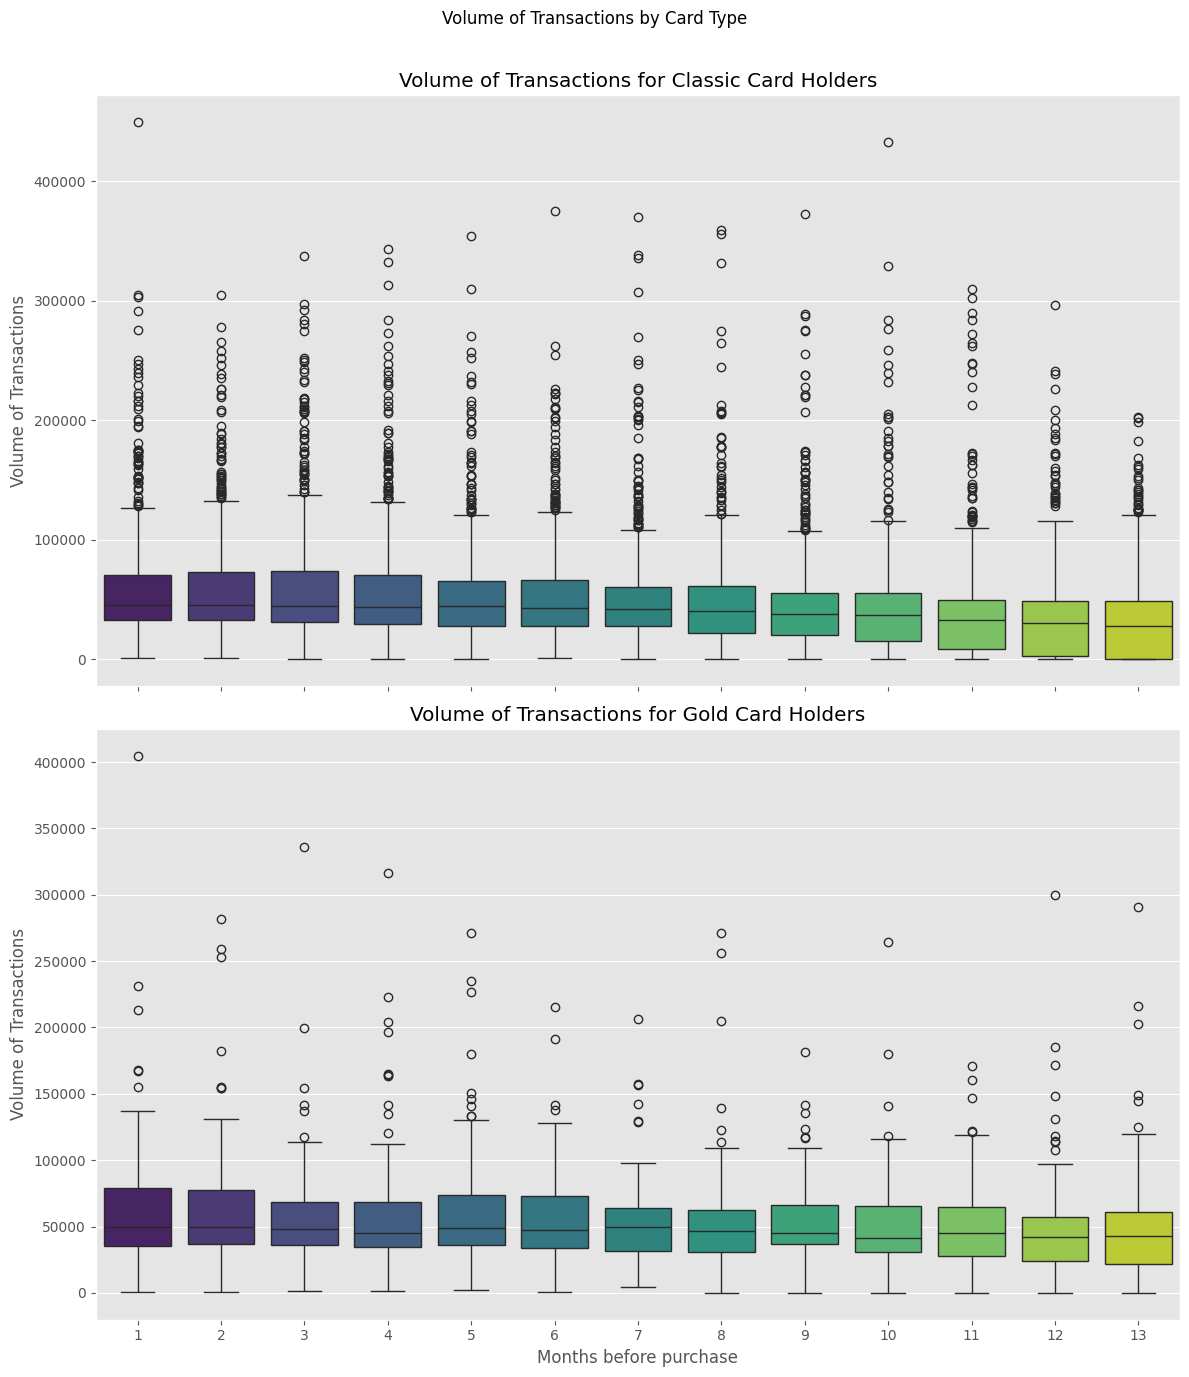

In [44]:
classic_card_type_df = card_owners[card_owners['card_type'] == 'classic']
gold_card_type_df = card_owners[card_owners['card_type'] == 'gold']

volume_month_diff_columns = [col for col in account_summary.columns if 'volume_month_diff_' in col]

classic_data = []
gold_data = []

for col in volume_month_diff_columns:
    month_num = col.split('_')[-1]
    for value in classic_card_type_df[col]:
        classic_data.append({'Month': month_num, 'Volume': value, 'Card Type': 'Classic'})

for col in volume_month_diff_columns:
    month_num = col.split('_')[-1]
    for value in gold_card_type_df[col]:
        gold_data.append({'Month': month_num, 'Volume': value, 'Card Type': 'Gold'})

combined_data = classic_data + gold_data

combined_df = pd.DataFrame(combined_data)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 14), sharex=True)

sns.boxplot(ax=axes[0], x='Month', y='Volume', data=combined_df[combined_df['Card Type'] == 'Classic'], palette='viridis', hue='Month')
axes[0].set_title('Volume of Transactions for Classic Card Holders')
axes[0].set_xlabel('Months before purchase')
axes[0].set_ylabel('Volume of Transactions')

sns.boxplot(ax=axes[1], x='Month', y='Volume', data=combined_df[combined_df['Card Type'] == 'Gold'], palette='viridis', hue='Month')
axes[1].set_title('Volume of Transactions for Gold Card Holders')
axes[1].set_xlabel('Months before purchase')
axes[1].set_ylabel('Volume of Transactions')

fig.suptitle('Volume of Transactions by Card Type')
plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()

### Age distribution

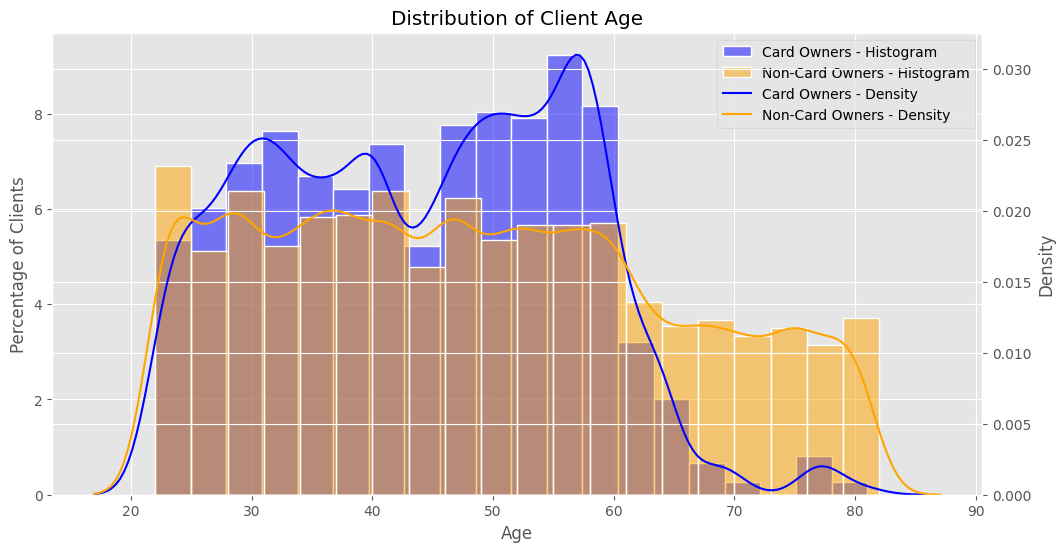

In [45]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot histograms with percentage normalization on the left y-axis
sns.histplot(card_owners['client_age'], bins=20, stat='percent', kde=False, color='blue', edgecolor='white', linewidth=1, label='Card Owners - Histogram', alpha=0.5, ax=ax1)
sns.histplot(non_card_owners['client_age'], bins=20, stat='percent', kde=False, color='orange', edgecolor='white', linewidth=1, label='Non-Card Owners - Histogram', alpha=0.5, ax=ax1)

# Set up the second y-axis
ax2 = ax1.twinx()

# Plot density plots on the right y-axis
sns.kdeplot(card_owners['client_age'], bw_adjust=0.5, color='blue', label='Card Owners - Density', ax=ax2)
sns.kdeplot(non_card_owners['client_age'], bw_adjust=0.5, color='orange', label='Non-Card Owners - Density', ax=ax2)

# Set the titles and labels
ax1.set_title('Distribution of Client Age')
ax1.set_xlabel('Age')
ax1.set_ylabel('Percentage of Clients')
ax2.set_ylabel('Density')

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

# Show the plot
plt.grid(True)
plt.show()

## Feature Engineering

### Demographic-Based Features
1. Defining Age Groups
The `pd.cut()` function bins continuous data into discrete intervals based on specified edges, with the default behavior including the left edge and excluding the right edge of each interval. The ages get binned by assigning each age value to an interval defined by specified edges, such as [0, 20), [20, 30), and so on, where each interval includes the left edge and excludes the right edge by default.

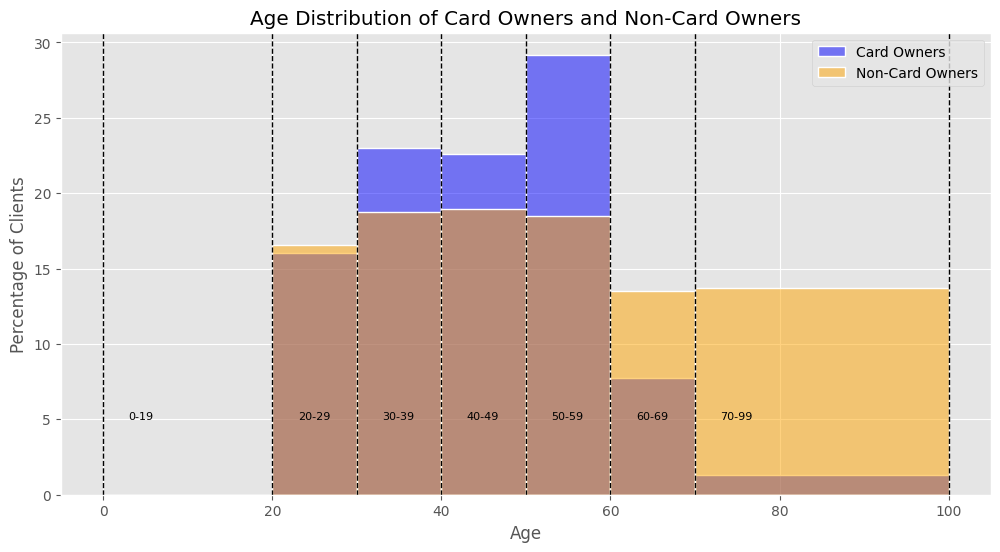

In [46]:
age_brackets = [0, 20, 30, 40, 50, 60, 70, 100]

plt.figure(figsize=(12, 6))
sns.histplot(card_owners['client_age'], bins=age_brackets, stat='percent', kde=False, color='blue', edgecolor='white', linewidth=1, label='Card Owners', alpha=0.5)
sns.histplot(non_card_owners['client_age'], bins=age_brackets, stat='percent', kde=False, color='orange', edgecolor='white', linewidth=1, label='Non-Card Owners', alpha=0.5)

for age_bracket in age_brackets:
    plt.axvline(age_bracket, color='black', linestyle='--', linewidth=1)
    
plt.title('Age Distribution of Card Owners and Non-Card Owners')
plt.xlabel('Age')
plt.ylabel('Percentage of Clients')

for i in range(len(age_brackets) - 1):
    plt.text(age_brackets[i] + 3, 5, f'{age_brackets[i]}-{age_brackets[i+1]-1}', fontsize=8, color='black')
    
plt.legend()
plt.grid(True)

plt.show()

In [47]:
client_df['age_bracket'] = pd.cut(client_df['client_age'], bins=age_brackets, right=False)

age_bracket_counts = client_df['age_bracket'].value_counts().reset_index()
age_bracket_counts.columns = ['Age Bracket', 'Number of Clients']

age_bracket_counts

,Age Bracket,Number of Clients
0,"[50, 60)",767
1,"[40, 50)",732
2,"[30, 40)",729
3,"[20, 30)",611
4,"[60, 70)",460
5,"[70, 100)",416
6,"[0, 20)",0


2. Age at Loan

In [48]:
client_df['client_age_at_loan'] = (pd.to_datetime(client_df['loan_date']) - pd.to_datetime(client_df['client_birth_date'])).dt.days // 365

client_df.head(5)

,disp_id,client_id,account_id,account_district_id,account_frequency,account_date,client_district_id,client_gender,client_birth_date,client_age,ordertype_HOUSEHOLD,ordertype_INSURANCE PAYMENT,ordertype_LEASING,ordertype_LOAN PAYMENT,ordertype_MISSING,loan_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,card_id,card_type,card_issued,district_id_x,client_district_district_name,client_district_region,client_district_population,client_district_n_municipalities_with_inhabitants_lt_499,client_district_n_municipalities_with_inhabitants_500_to_1999,client_district_n_municipalities_with_inhabitants_2000_to_9999,client_district_n_municipalities_with_inhabitants_gt_10000,client_district_n_cities,client_district_ratio_urban_inhabitants,client_district_average_salary,client_district_unemployment_rate_95,client_district_unemployment_rate_96,client_district_enterpreneurs_per_1000_inhabitants,client_district_n_commited_crimes_95,client_district_n_commited_crimes_96,district_id_y,account_district_district_name,account_district_region,account_district_population,account_district_n_municipalities_with_inhabitants_lt_499,account_district_n_municipalities_with_inhabitants_500_to_1999,account_district_n_municipalities_with_inhabitants_2000_to_9999,account_district_n_municipalities_with_inhabitants_gt_10000,account_district_n_cities,account_district_ratio_urban_inhabitants,account_district_average_salary,account_district_unemployment_rate_95,account_district_unemployment_rate_96,account_district_enterpreneurs_per_1000_inhabitants,account_district_n_commited_crimes_95,account_district_n_commited_crimes_96,has_card,volume_month_diff_1,volume_month_diff_2,volume_month_diff_3,volume_month_diff_4,volume_month_diff_5,volume_month_diff_6,volume_month_diff_7,volume_month_diff_8,volume_month_diff_9,volume_month_diff_10,volume_month_diff_11,volume_month_diff_12,volume_month_diff_13,withdrawal_month_diff_1,withdrawal_month_diff_2,withdrawal_month_diff_3,withdrawal_month_diff_4,withdrawal_month_diff_5,withdrawal_month_diff_6,withdrawal_month_diff_7,withdrawal_month_diff_8,withdrawal_month_diff_9,withdrawal_month_diff_10,withdrawal_month_diff_11,withdrawal_month_diff_12,withdrawal_month_diff_13,credit_month_diff_1,credit_month_diff_2,credit_month_diff_3,credit_month_diff_4,credit_month_diff_5,credit_month_diff_6,credit_month_diff_7,credit_month_diff_8,credit_month_diff_9,credit_month_diff_10,credit_month_diff_11,credit_month_diff_12,credit_month_diff_13,n_transactions_month_diff_1,n_transactions_month_diff_2,n_transactions_month_diff_3,n_transactions_month_diff_4,n_transactions_month_diff_5,n_transactions_month_diff_6,n_transactions_month_diff_7,n_transactions_month_diff_8,n_transactions_month_diff_9,n_transactions_month_diff_10,n_transactions_month_diff_11,n_transactions_month_diff_12,n_transactions_month_diff_13,balance_month_diff_1,balance_month_diff_2,balance_month_diff_3,balance_month_diff_4,balance_month_diff_5,balance_month_diff_6,balance_month_diff_7,balance_month_diff_8,balance_month_diff_9,balance_month_diff_10,balance_month_diff_11,balance_month_diff_12,balance_month_diff_13,age_bracket,client_age_at_loan
0,1,1,1,18,MONTHLY CHARGES,1995-03-24,18,FEMALE,1970-12-13,29,1.0,0.0,0.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1998-09-18,18,Pisek,south Bohemia,70699,60,13,2,1,4,65.3,8968,2.83,3.35,131,1740,1910,18,Pisek,south Bohemia,70699,60,13,2,1,4,65.3,8968,2.83,3.35,131,1740,1910,False,6492.7,6221.0,6667.1,6212.3,7435.5,7018.6,6701.9,9091.5,10907.2,7318.0,6218.0,6600.6,8282.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6492.7,6221.0,6667.1,6212.3,7435.5,7018.6,6701.9,9091.5,10907.2,7318.0,6218.0,6600.6,8282.7,5.0,4.0,5.0,4.0,6.0,5.0,5.0,10.0,5.0,5.0,4.0,5.0,6.0,338855.2,332362.5,326141.5,319474.4,313262.1,305826.6,298808.0,292106.1,283014.6,272107.4,264789.4,258571.4,251970.8,"[20, 30)",NaN
1,2,2,2,1,MONTHLY CHARGES,1993-02-26,1,MALE,1945-02-04,54,1.0,0.0,0.0,1.0,0.0,4959.0,1994-01-05,80952.0,24.0,3373.0,"contract finished, no probl

### Temporal Features
Account age

In [49]:
client_df['account_age'] = (pd.to_datetime('2000-01-01') - pd.to_datetime(client_df['account_date'])).dt.days // 365

client_df.head(5)

,disp_id,client_id,account_id,account_district_id,account_frequency,account_date,client_district_id,client_gender,client_birth_date,client_age,ordertype_HOUSEHOLD,ordertype_INSURANCE PAYMENT,ordertype_LEASING,ordertype_LOAN PAYMENT,ordertype_MISSING,loan_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,card_id,card_type,card_issued,district_id_x,client_district_district_name,client_district_region,client_district_population,client_district_n_municipalities_with_inhabitants_lt_499,client_district_n_municipalities_with_inhabitants_500_to_1999,client_district_n_municipalities_with_inhabitants_2000_to_9999,client_district_n_municipalities_with_inhabitants_gt_10000,client_district_n_cities,client_district_ratio_urban_inhabitants,client_district_average_salary,client_district_unemployment_rate_95,client_district_unemployment_rate_96,client_district_enterpreneurs_per_1000_inhabitants,client_district_n_commited_crimes_95,client_district_n_commited_crimes_96,district_id_y,account_district_district_name,account_district_region,account_district_population,account_district_n_municipalities_with_inhabitants_lt_499,account_district_n_municipalities_with_inhabitants_500_to_1999,account_district_n_municipalities_with_inhabitants_2000_to_9999,account_district_n_municipalities_with_inhabitants_gt_10000,account_district_n_cities,account_district_ratio_urban_inhabitants,account_district_average_salary,account_district_unemployment_rate_95,account_district_unemployment_rate_96,account_district_enterpreneurs_per_1000_inhabitants,account_district_n_commited_crimes_95,account_district_n_commited_crimes_96,has_card,volume_month_diff_1,volume_month_diff_2,volume_month_diff_3,volume_month_diff_4,volume_month_diff_5,volume_month_diff_6,volume_month_diff_7,volume_month_diff_8,volume_month_diff_9,volume_month_diff_10,volume_month_diff_11,volume_month_diff_12,volume_month_diff_13,withdrawal_month_diff_1,withdrawal_month_diff_2,withdrawal_month_diff_3,withdrawal_month_diff_4,withdrawal_month_diff_5,withdrawal_month_diff_6,withdrawal_month_diff_7,withdrawal_month_diff_8,withdrawal_month_diff_9,withdrawal_month_diff_10,withdrawal_month_diff_11,withdrawal_month_diff_12,withdrawal_month_diff_13,credit_month_diff_1,credit_month_diff_2,credit_month_diff_3,credit_month_diff_4,credit_month_diff_5,credit_month_diff_6,credit_month_diff_7,credit_month_diff_8,credit_month_diff_9,credit_month_diff_10,credit_month_diff_11,credit_month_diff_12,credit_month_diff_13,n_transactions_month_diff_1,n_transactions_month_diff_2,n_transactions_month_diff_3,n_transactions_month_diff_4,n_transactions_month_diff_5,n_transactions_month_diff_6,n_transactions_month_diff_7,n_transactions_month_diff_8,n_transactions_month_diff_9,n_transactions_month_diff_10,n_transactions_month_diff_11,n_transactions_month_diff_12,n_transactions_month_diff_13,balance_month_diff_1,balance_month_diff_2,balance_month_diff_3,balance_month_diff_4,balance_month_diff_5,balance_month_diff_6,balance_month_diff_7,balance_month_diff_8,balance_month_diff_9,balance_month_diff_10,balance_month_diff_11,balance_month_diff_12,balance_month_diff_13,age_bracket,client_age_at_loan,account_age
0,1,1,1,18,MONTHLY CHARGES,1995-03-24,18,FEMALE,1970-12-13,29,1.0,0.0,0.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1998-09-18,18,Pisek,south Bohemia,70699,60,13,2,1,4,65.3,8968,2.83,3.35,131,1740,1910,18,Pisek,south Bohemia,70699,60,13,2,1,4,65.3,8968,2.83,3.35,131,1740,1910,False,6492.7,6221.0,6667.1,6212.3,7435.5,7018.6,6701.9,9091.5,10907.2,7318.0,6218.0,6600.6,8282.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6492.7,6221.0,6667.1,6212.3,7435.5,7018.6,6701.9,9091.5,10907.2,7318.0,6218.0,6600.6,8282.7,5.0,4.0,5.0,4.0,6.0,5.0,5.0,10.0,5.0,5.0,4.0,5.0,6.0,338855.2,332362.5,326141.5,319474.4,313262.1,305826.6,298808.0,292106.1,283014.6,272107.4,264789.4,258571.4,251970.8,"[20, 30)",NaN,4
1,2,2,2,1,MONTHLY CHARGES,1993-02-26,1,MALE,1945-02-04,54,1.0,0.0,0.0,1.0,0.0,4959.0,1994-01-05,80952.0,24.0,3373.0,"contract fini

### Financial Features
Amount of Loan Paid already

In [50]:
client_df['total_loan_amount_paid'] = client_df['loan_payments'] * client_df['loan_duration']

Average Monthly Payment Ratio: Calculate the ratio of monthly loan payment to average salary in the account's district.

In [51]:
client_df['monthly_payment_ratio'] = client_df['loan_payments'] / client_df['account_district_average_salary']

### District Features
Client-Account Region Match: Create a variable indicating if the client and account regions match.

In [52]:
client_df['region_match'] = client_df['client_district_region'] == client_df['account_district_region']

District Population Density: Calculate the population density for client and account districts (if area data is available).

In [53]:
client_df['client_district_population_density'] = client_df['client_district_population'] / client_df['client_district_n_cities']
client_df['account_district_population_density'] = client_df['account_district_population'] / client_df['account_district_n_cities']

### Event-Based Statistics

In [54]:
transactions_monthly['card_issued'] = pd.to_datetime(transactions_monthly['card_issued'])

transactions_monthly['month'] = transactions_monthly['month'].apply(lambda x: x.to_timestamp() if isinstance(x, pd.Period) else x)

transactions_filtered = transactions_monthly[transactions_monthly['month'] < transactions_monthly['card_issued']]

stat_columns = ['volume', 'credit', 'withdrawal', 'n_transactions', 'balance']

stats = transactions_filtered.groupby('account_id')[stat_columns].agg(['mean', 'std', 'min', 'max', 'sum', 'median']).reset_index()

stats.columns = ['account_id'] + [f"pre_card_{col[0]}_{col[1]}" for col in stats.columns[1:]]

client_df = client_df.merge(stats, on='account_id', how='left')

client_df.head(5)

,disp_id,client_id,account_id,account_district_id,account_frequency,account_date,client_district_id,client_gender,client_birth_date,client_age,ordertype_HOUSEHOLD,ordertype_INSURANCE PAYMENT,ordertype_LEASING,ordertype_LOAN PAYMENT,ordertype_MISSING,loan_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,card_id,card_type,card_issued,district_id_x,client_district_district_name,client_district_region,client_district_population,client_district_n_municipalities_with_inhabitants_lt_499,client_district_n_municipalities_with_inhabitants_500_to_1999,client_district_n_municipalities_with_inhabitants_2000_to_9999,client_district_n_municipalities_with_inhabitants_gt_10000,client_district_n_cities,client_district_ratio_urban_inhabitants,client_district_average_salary,client_district_unemployment_rate_95,client_district_unemployment_rate_96,client_district_enterpreneurs_per_1000_inhabitants,client_district_n_commited_crimes_95,client_district_n_commited_crimes_96,district_id_y,account_district_district_name,account_district_region,account_district_population,account_district_n_municipalities_with_inhabitants_lt_499,account_district_n_municipalities_with_inhabitants_500_to_1999,account_district_n_municipalities_with_inhabitants_2000_to_9999,account_district_n_municipalities_with_inhabitants_gt_10000,account_district_n_cities,account_district_ratio_urban_inhabitants,account_district_average_salary,account_district_unemployment_rate_95,account_district_unemployment_rate_96,account_district_enterpreneurs_per_1000_inhabitants,account_district_n_commited_crimes_95,account_district_n_commited_crimes_96,has_card,volume_month_diff_1,volume_month_diff_2,volume_month_diff_3,volume_month_diff_4,volume_month_diff_5,volume_month_diff_6,volume_month_diff_7,volume_month_diff_8,volume_month_diff_9,volume_month_diff_10,volume_month_diff_11,volume_month_diff_12,volume_month_diff_13,withdrawal_month_diff_1,withdrawal_month_diff_2,withdrawal_month_diff_3,withdrawal_month_diff_4,withdrawal_month_diff_5,withdrawal_month_diff_6,withdrawal_month_diff_7,withdrawal_month_diff_8,withdrawal_month_diff_9,withdrawal_month_diff_10,withdrawal_month_diff_11,withdrawal_month_diff_12,withdrawal_month_diff_13,credit_month_diff_1,credit_month_diff_2,credit_month_diff_3,credit_month_diff_4,credit_month_diff_5,credit_month_diff_6,credit_month_diff_7,credit_month_diff_8,credit_month_diff_9,credit_month_diff_10,credit_month_diff_11,credit_month_diff_12,credit_month_diff_13,n_transactions_month_diff_1,n_transactions_month_diff_2,n_transactions_month_diff_3,n_transactions_month_diff_4,n_transactions_month_diff_5,n_transactions_month_diff_6,n_transactions_month_diff_7,n_transactions_month_diff_8,n_transactions_month_diff_9,n_transactions_month_diff_10,n_transactions_month_diff_11,n_transactions_month_diff_12,n_transactions_month_diff_13,balance_month_diff_1,balance_month_diff_2,balance_month_diff_3,balance_month_diff_4,balance_month_diff_5,balance_month_diff_6,balance_month_diff_7,balance_month_diff_8,balance_month_diff_9,balance_month_diff_10,balance_month_diff_11,balance_month_diff_12,balance_month_diff_13,age_bracket,client_age_at_loan,account_age,total_loan_amount_paid,monthly_payment_ratio,region_match,client_district_population_density,account_district_population_density,pre_card_volume_mean,pre_card_volume_std,pre_card_volume_min,pre_card_volume_max,pre_card_volume_sum,pre_card_volume_median,pre_card_credit_mean,pre_card_credit_std,pre_card_credit_min,pre_card_credit_max,pre_card_credit_sum,pre_card_credit_median,pre_card_withdrawal_mean,pre_card_withdrawal_std,pre_card_withdrawal_min,pre_card_withdrawal_max,pre_card_withdrawal_sum,pre_card_withdrawal_median,pre_card_n_transactions_mean,pre_card_n_transactions_std,pre_card_n_transactions_min,pre_card_n_transactions_max,pre_card_n_transactions_sum,pre_card_n_transactions_median,pre_card_balance_mean,pre_card_balance_std,pre_card_balance_min,pre_card_balance_max,pre_card_balance_sum,pre_card_balance_median
0,1,1,1

In [55]:
pd.set_option('display.max_columns', None) 
client_df.columns

Index(['disp_id', 'client_id', 'account_id', 'account_district_id',
       'account_frequency', 'account_date', 'client_district_id',
       'client_gender', 'client_birth_date', 'client_age',
       ...
       'pre_card_n_transactions_min', 'pre_card_n_transactions_max',
       'pre_card_n_transactions_sum', 'pre_card_n_transactions_median',
       'pre_card_balance_mean', 'pre_card_balance_std', 'pre_card_balance_min',
       'pre_card_balance_max', 'pre_card_balance_sum',
       'pre_card_balance_median'],
      dtype='object', length=160)

### Statistical Metrics on the Rollup Window

In [56]:
month_diff_columns = [col for col in client_df.columns if 'month_diff' in col]

prefixes = set(col.rsplit('_', 2)[0] for col in month_diff_columns)

for prefix in prefixes:
    cols = [col for col in month_diff_columns if col.startswith(prefix)]
    client_df[f'{prefix}_mean'] = client_df[cols].mean(axis=1)
    client_df[f'{prefix}_std'] = client_df[cols].std(axis=1)
    client_df[f'{prefix}_min'] = client_df[cols].min(axis=1)
    client_df[f'{prefix}_max'] = client_df[cols].max(axis=1)
    client_df[f'{prefix}_sum'] = client_df[cols].sum(axis=1)
    client_df[f'{prefix}_median'] = client_df[cols].median(axis=1)

In [57]:
client_df.head(5)

,disp_id,client_id,account_id,account_district_id,account_frequency,account_date,client_district_id,client_gender,client_birth_date,client_age,ordertype_HOUSEHOLD,ordertype_INSURANCE PAYMENT,ordertype_LEASING,ordertype_LOAN PAYMENT,ordertype_MISSING,loan_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,card_id,card_type,card_issued,district_id_x,client_district_district_name,client_district_region,client_district_population,client_district_n_municipalities_with_inhabitants_lt_499,client_district_n_municipalities_with_inhabitants_500_to_1999,client_district_n_municipalities_with_inhabitants_2000_to_9999,client_district_n_municipalities_with_inhabitants_gt_10000,client_district_n_cities,client_district_ratio_urban_inhabitants,client_district_average_salary,client_district_unemployment_rate_95,client_district_unemployment_rate_96,client_district_enterpreneurs_per_1000_inhabitants,client_district_n_commited_crimes_95,client_district_n_commited_crimes_96,district_id_y,account_district_district_name,account_district_region,account_district_population,account_district_n_municipalities_with_inhabitants_lt_499,account_district_n_municipalities_with_inhabitants_500_to_1999,account_district_n_municipalities_with_inhabitants_2000_to_9999,account_district_n_municipalities_with_inhabitants_gt_10000,account_district_n_cities,account_district_ratio_urban_inhabitants,account_district_average_salary,account_district_unemployment_rate_95,account_district_unemployment_rate_96,account_district_enterpreneurs_per_1000_inhabitants,account_district_n_commited_crimes_95,account_district_n_commited_crimes_96,has_card,volume_month_diff_1,volume_month_diff_2,volume_month_diff_3,volume_month_diff_4,volume_month_diff_5,volume_month_diff_6,volume_month_diff_7,volume_month_diff_8,volume_month_diff_9,volume_month_diff_10,volume_month_diff_11,volume_month_diff_12,volume_month_diff_13,withdrawal_month_diff_1,withdrawal_month_diff_2,withdrawal_month_diff_3,withdrawal_month_diff_4,withdrawal_month_diff_5,withdrawal_month_diff_6,withdrawal_month_diff_7,withdrawal_month_diff_8,withdrawal_month_diff_9,withdrawal_month_diff_10,withdrawal_month_diff_11,withdrawal_month_diff_12,withdrawal_month_diff_13,credit_month_diff_1,credit_month_diff_2,credit_month_diff_3,credit_month_diff_4,credit_month_diff_5,credit_month_diff_6,credit_month_diff_7,credit_month_diff_8,credit_month_diff_9,credit_month_diff_10,credit_month_diff_11,credit_month_diff_12,credit_month_diff_13,n_transactions_month_diff_1,n_transactions_month_diff_2,n_transactions_month_diff_3,n_transactions_month_diff_4,n_transactions_month_diff_5,n_transactions_month_diff_6,n_transactions_month_diff_7,n_transactions_month_diff_8,n_transactions_month_diff_9,n_transactions_month_diff_10,n_transactions_month_diff_11,n_transactions_month_diff_12,n_transactions_month_diff_13,balance_month_diff_1,balance_month_diff_2,balance_month_diff_3,balance_month_diff_4,balance_month_diff_5,balance_month_diff_6,balance_month_diff_7,balance_month_diff_8,balance_month_diff_9,balance_month_diff_10,balance_month_diff_11,balance_month_diff_12,balance_month_diff_13,age_bracket,client_age_at_loan,account_age,total_loan_amount_paid,monthly_payment_ratio,region_match,client_district_population_density,account_district_population_density,pre_card_volume_mean,pre_card_volume_std,pre_card_volume_min,pre_card_volume_max,pre_card_volume_sum,pre_card_volume_median,pre_card_credit_mean,pre_card_credit_std,pre_card_credit_min,pre_card_credit_max,pre_card_credit_sum,pre_card_credit_median,pre_card_withdrawal_mean,pre_card_withdrawal_std,pre_card_withdrawal_min,pre_card_withdrawal_max,pre_card_withdrawal_sum,pre_card_withdrawal_median,pre_card_n_transactions_mean,pre_card_n_transactions_std,pre_card_n_transactions_min,pre_card_n_transactions_max,pre_card_n_transactions_sum,pre_card_n_transactions_median,pre_card_balance_mean,pre_card_balance_std,pre_card_balance_min,pre_card_balance_max,pre_card_balance_sum,pre_card_balance_median,volume_

### First and Last Quarter Rollup Window Statistics

In [58]:
month_diff_columns = [col for col in client_df.columns if 'month_diff' in col]

prefixes = set(col.rsplit('_', 3)[0] for col in month_diff_columns)

for prefix in prefixes:
    first_quarter_cols = [f'{prefix}_month_diff_{i}' for i in range(1, 4)]
    last_quarter_cols = [f'{prefix}_month_diff_{i}' for i in range(10, 13)]
    
    client_df[f'{prefix}_first_quarter_mean'] = client_df[first_quarter_cols].mean(axis=1)
    client_df[f'{prefix}_first_quarter_std'] = client_df[first_quarter_cols].std(axis=1)
    client_df[f'{prefix}_first_quarter_min'] = client_df[first_quarter_cols].min(axis=1)
    client_df[f'{prefix}_first_quarter_max'] = client_df[first_quarter_cols].max(axis=1)
    client_df[f'{prefix}_first_quarter_sum'] = client_df[first_quarter_cols].sum(axis=1)
    client_df[f'{prefix}_first_quarter_median'] = client_df[first_quarter_cols].median(axis=1)
    
    client_df[f'{prefix}_last_quarter_mean'] = client_df[last_quarter_cols].mean(axis=1)
    client_df[f'{prefix}_last_quarter_std'] = client_df[last_quarter_cols].std(axis=1)
    client_df[f'{prefix}_last_quarter_min'] = client_df[last_quarter_cols].min(axis=1)
    client_df[f'{prefix}_last_quarter_max'] = client_df[last_quarter_cols].max(axis=1)
    client_df[f'{prefix}_last_quarter_sum'] = client_df[last_quarter_cols].sum(axis=1)
    client_df[f'{prefix}_last_quarter_median'] = client_df[last_quarter_cols].median(axis=1)

### Looking at the effect of the new features

#### Impact of variance

In [59]:
numerical_cols = client_df.select_dtypes(include=['number']).columns

numerical_variance = client_df[numerical_cols].var()

pd.DataFrame(numerical_variance.sort_values().head(20))

,0
withdrawal_month_diff_7,0.0
withdrawal_first_quarter_median,0.0
withdrawal_first_quarter_sum,0.0
withdrawal_first_quarter_max,0.0
withdrawal_first_quarter_min,0.0
withdrawal_first_quarter_std,0.0
withdrawal_first_quarter_mean,0.0
withdrawal_month_diff_1,0.0
withdrawal_month_diff_3,0.0
withdrawal_month_diff_4,0.0


In [60]:
from sklearn.feature_selection import VarianceThreshold
 
vt = VarianceThreshold(threshold=1)
vt.fit(client_df.select_dtypes(include='number'))

low_variance_cols = client_df.select_dtypes(include='number').columns[~vt.get_support()]

client_df.drop(low_variance_cols, axis=1, inplace=True)

#### Looking at temporal client traits

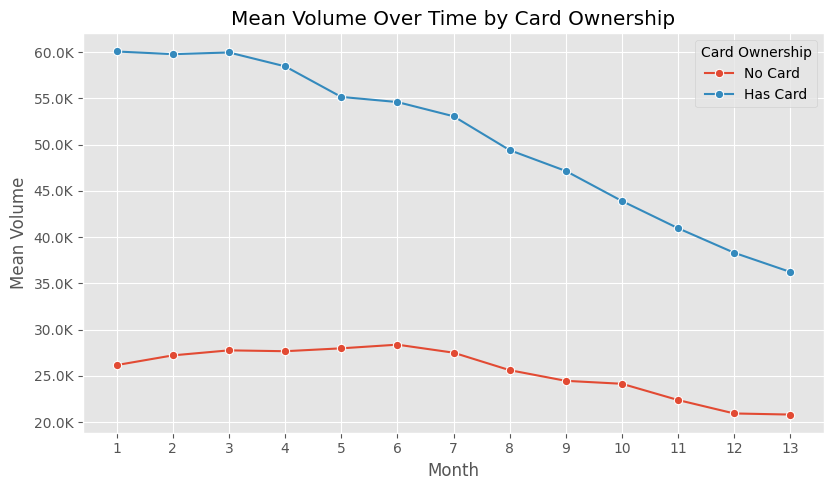

In [61]:
from src.plot_utils import plot_agg_variables

plot_agg_variables(client_df, 'volume', ['mean'])

## Train-Test-Split

In [62]:
from src.train_utils import train_test_split_bal

cleaned_client_df = client_df.loc[:, ~client_df.columns.str.contains('_id|id_|_date|card_issued|age_bracket|card_type')]

X_train, X_test, y_train, y_test = train_test_split_bal(df=cleaned_client_df, target_column='has_card', test_size=0.2, random_state=1337, balancing_technique='undersample')

In [63]:
print('Train set:')
print(y_train.value_counts(normalize=True))
print('\nTest set:')
print(y_test.value_counts(normalize=True))

Train set:
has_card
False    0.5
True     0.5
Name: proportion, dtype: float64

Test set:
has_card
False    0.792732
True     0.207268
Name: proportion, dtype: float64


## Baseline Model
Erstellen eines Baseline Modelles mittels logistischer Regression und den Informationen “Alter”,
“Geschlecht”, “Domizilregion”, “Vermögen” und “Umsatz” vor Kreditkartenkauf.

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 327.74it/s]


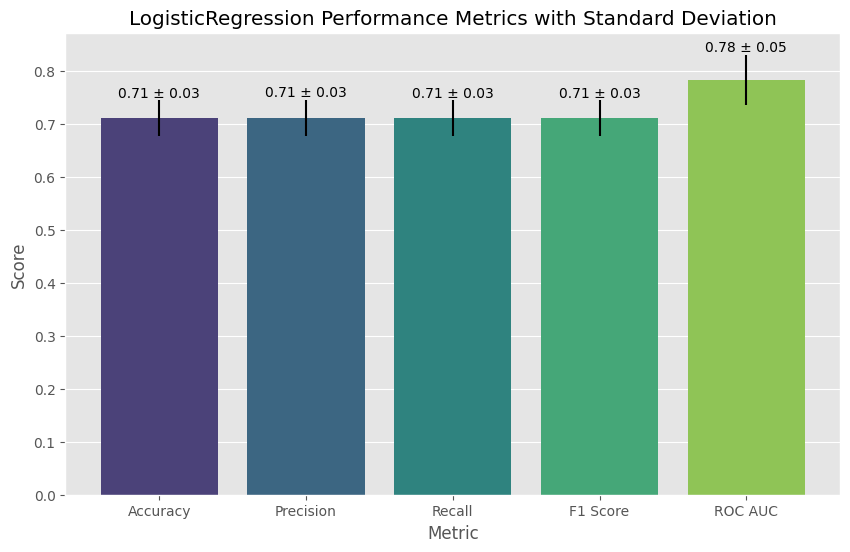

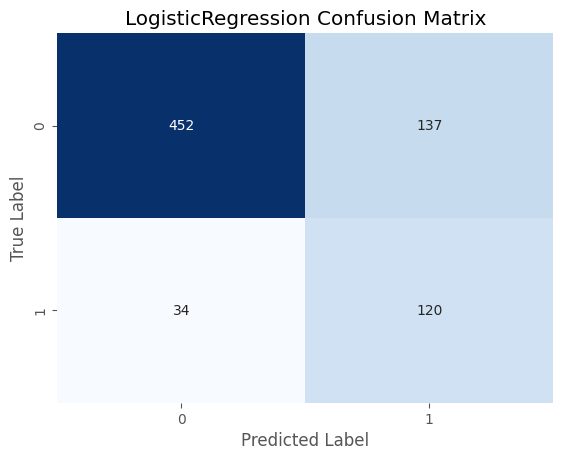

In [64]:
from src.plot_utils import (plot_roc_curve, 
                            plot_confusion_matrix, 
                            plot_lift_curve, 
                            plot_precision_recall_curve, 
                            plot_metrics)

from src.train_utils import (cross_validate,
                             build_preprocessor_pipeline)

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

baseline_columns = ['client_age', 'client_gender', 'client_district_region']

baseline_preprocessor, baseline_column_selection = build_preprocessor_pipeline(X_train, 
                                                                               include_columns=baseline_columns, 
                                                                               regex_columns='(volume|balance)')

base_pipeline = Pipeline([
    ('preprocessor', baseline_preprocessor),
    ('classifier', LogisticRegression(random_state=1337, max_iter=10_000))
])

(base_estimator, 
 base_params, 
 base_metrics_df, 
 base_roc_curves, 
 base_pr_curves, 
 base_lift_probs, 
 base_true_labels) = cross_validate(base_pipeline, 
                                    baseline_column_selection, 
                                    y_train)

model_name = base_estimator.named_steps['classifier'].__class__.__name__

plot_metrics(base_metrics_df, model_name)
plot_confusion_matrix(base_estimator, X_test[baseline_column_selection.columns], y_test, model_name)

In [65]:
base_metrics_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,0.705882,0.706407,0.705882,0.705695,0.782148
1,0.708861,0.709285,0.708861,0.708757,0.781228
2,0.742616,0.743402,0.742616,0.742359,0.814058
3,0.658228,0.658227,0.658228,0.658216,0.708446
4,0.738397,0.740199,0.738397,0.737977,0.831149


## Further Model Candidates

### Logistic Regression

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 3903.13it/s]


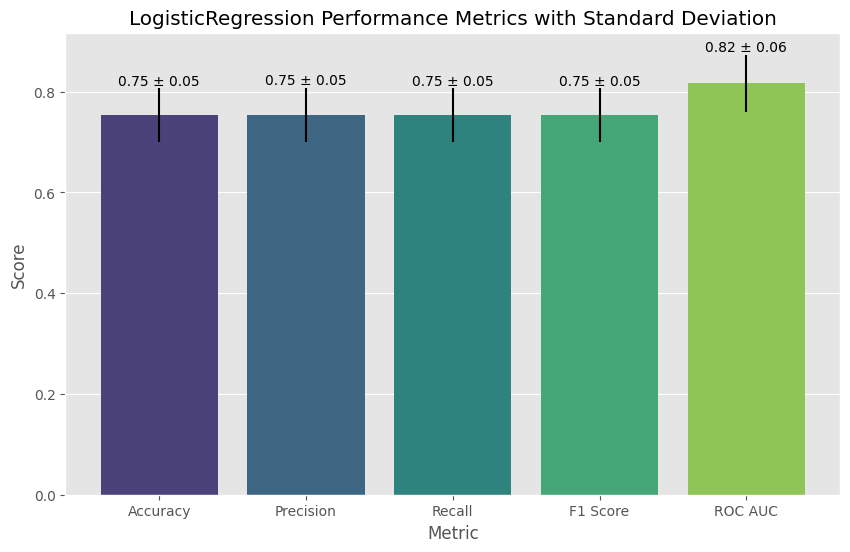

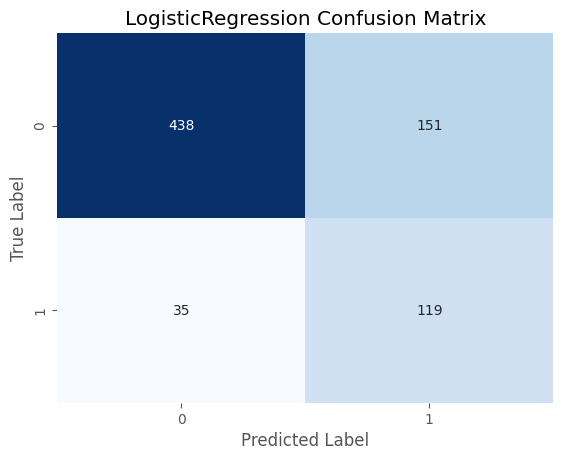

In [66]:
all_vars_prep_pipeline, all_vars_column_selection  = build_preprocessor_pipeline(X_train, include_columns=X_train.columns.tolist())

lr_pipeline = Pipeline([
    ('preprocessor', all_vars_prep_pipeline),
    ('classifier', LogisticRegression(random_state=1337, max_iter=100_000, solver='saga'))
])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
}

(lr_estimator,
 lr_params,
 lr_metrics_df,
 lr_roc_curves,
 lr_pr_curves,
 lr_lift_probs,
 lr_true_labels) = cross_validate(lr_pipeline, all_vars_column_selection, y_train, param_grid=param_grid)

model_name = lr_estimator.named_steps['classifier'].__class__.__name__
plot_metrics(lr_metrics_df, model_name)
plot_confusion_matrix(lr_estimator, X_test[all_vars_column_selection.columns], y_test, model_name)

### Decision Tree

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 4131.51it/s]


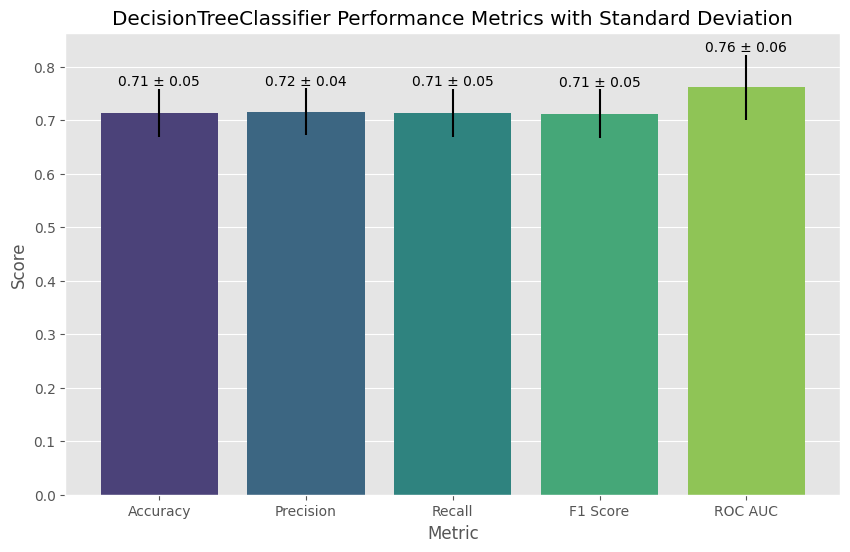

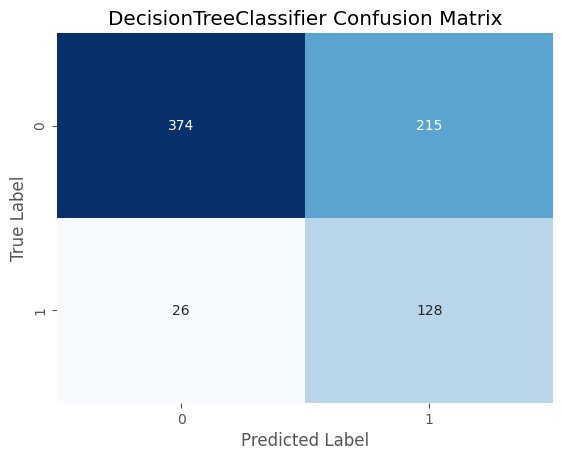

In [67]:
from sklearn.tree import DecisionTreeClassifier

dt_pipeline = Pipeline([
    ('preprocessor', all_vars_prep_pipeline),
    ('classifier', DecisionTreeClassifier(random_state=1337))
])

param_grid = {
    'classifier__max_depth': [5, 10, 20, 30, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

(dt_estimator, 
 dt_params, 
 dt_metrics_df, 
 dt_roc_curves, 
 dt_pr_curves, 
 dt_lift_probs, 
 dt_true_labels) = cross_validate(pipeline=dt_pipeline, 
                                  X=all_vars_column_selection, 
                                  y=y_train,
                                  param_grid=param_grid)

model_name = dt_estimator.named_steps['classifier'].__class__.__name__
plot_metrics(dt_metrics_df, model_name)
plot_confusion_matrix(dt_estimator, X_test[all_vars_column_selection.columns], y_test, model_name)

## Random Forest

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 5143.86it/s]


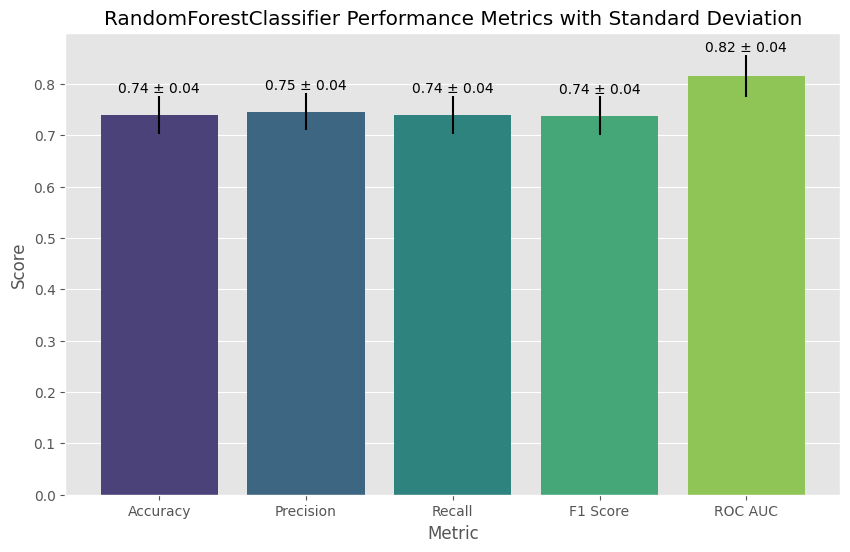

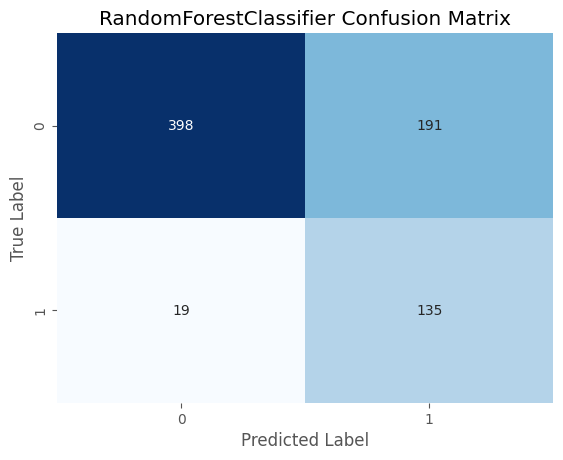

In [68]:
from sklearn.ensemble import RandomForestClassifier

all_vars_prep_pipeline, all_vars_column_selection = build_preprocessor_pipeline(X_train, include_columns=X_train.columns.tolist())

rf_pipeline = Pipeline([
    ('preprocessor', all_vars_prep_pipeline),
    ('classifier', RandomForestClassifier(random_state=1337))
])

param_grid = {
    'classifier__max_depth': [5, 10, 20, 30, 50],
    'classifier__n_estimators': [10, 20, 30]
}

(rf_estimator, 
 rf_params, 
 rf_metrics_df, 
 rf_roc_curves, 
 rf_pr_curves, 
 rf_lift_probs, 
 rf_true_labels) = cross_validate(rf_pipeline, 
                                  X_train[all_vars_column_selection.columns], 
                                  y_train, 
                                  param_grid=param_grid)

model_name = rf_estimator.named_steps['classifier'].__class__.__name__

plot_metrics(rf_metrics_df, model_name)
plot_confusion_matrix(rf_estimator, X_test[all_vars_column_selection.columns], y_test, model_name)

## Bagging

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 3075.45it/s]


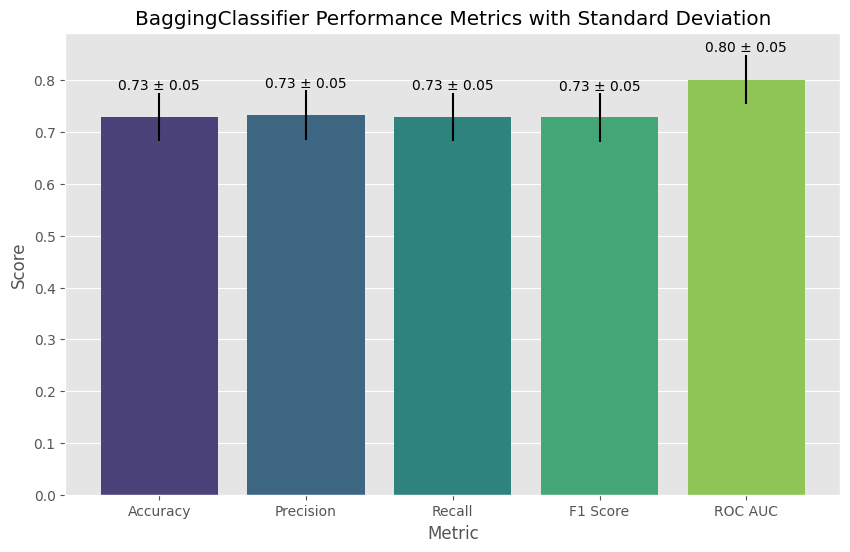

In [69]:
from sklearn.ensemble import BaggingClassifier

bg_pipeline = Pipeline([
    ('preprocessor', all_vars_prep_pipeline),
    ('classifier', BaggingClassifier(random_state=1337))
])

param_grid = {
    'classifier__n_estimators': [10, 20, 30],
    'classifier__max_features': [10, 20, 30, 40, 50]
}

(bg_estimator, 
 bg_params, 
 bg_metrics_df, 
 bg_roc_curves, 
 bg_pr_curves, 
 bg_lift_probs, 
 bg_true_labels) = cross_validate(bg_pipeline,
                                  all_vars_column_selection, 
                                  y_train, 
                                  param_grid=param_grid)

model_name = bg_estimator.named_steps['classifier'].__class__.__name__

plot_metrics(bg_metrics_df, model_name)

## Boosting

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 4756.53it/s]


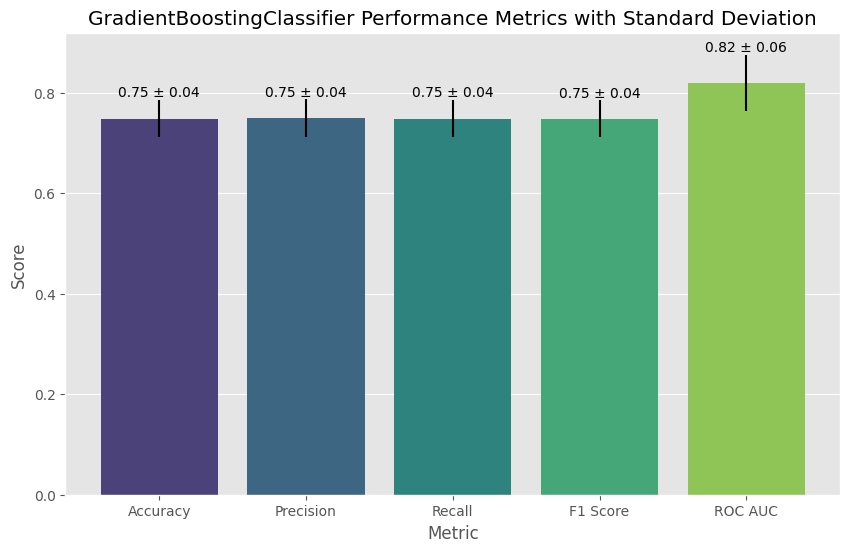

In [70]:
from sklearn.ensemble import GradientBoostingClassifier

bt_pipeline = Pipeline([
    ('preprocessor', all_vars_prep_pipeline),
    ('classifier', GradientBoostingClassifier(random_state=1337))
])

param_grid = {
    'classifier__n_estimators': [10, 20, 30],
    'classifier__learning_rate': [0.01, 0.1, 1],
    'classifier__max_depth': [5, 10, 20]
}

(bt_estimator, 
 bt_params, 
 bt_metrics_df, 
 bt_roc_curves, 
 bt_pr_curves, 
 bt_lift_probs, 
 bt_true_labels) = cross_validate(bt_pipeline,
                                  all_vars_column_selection, 
                                  y_train, 
                                  param_grid=param_grid)

model_name = bt_estimator.named_steps['classifier'].__class__.__name__

plot_metrics(bt_metrics_df, model_name)

## Comparing the Model Candidates

### ROC Curves

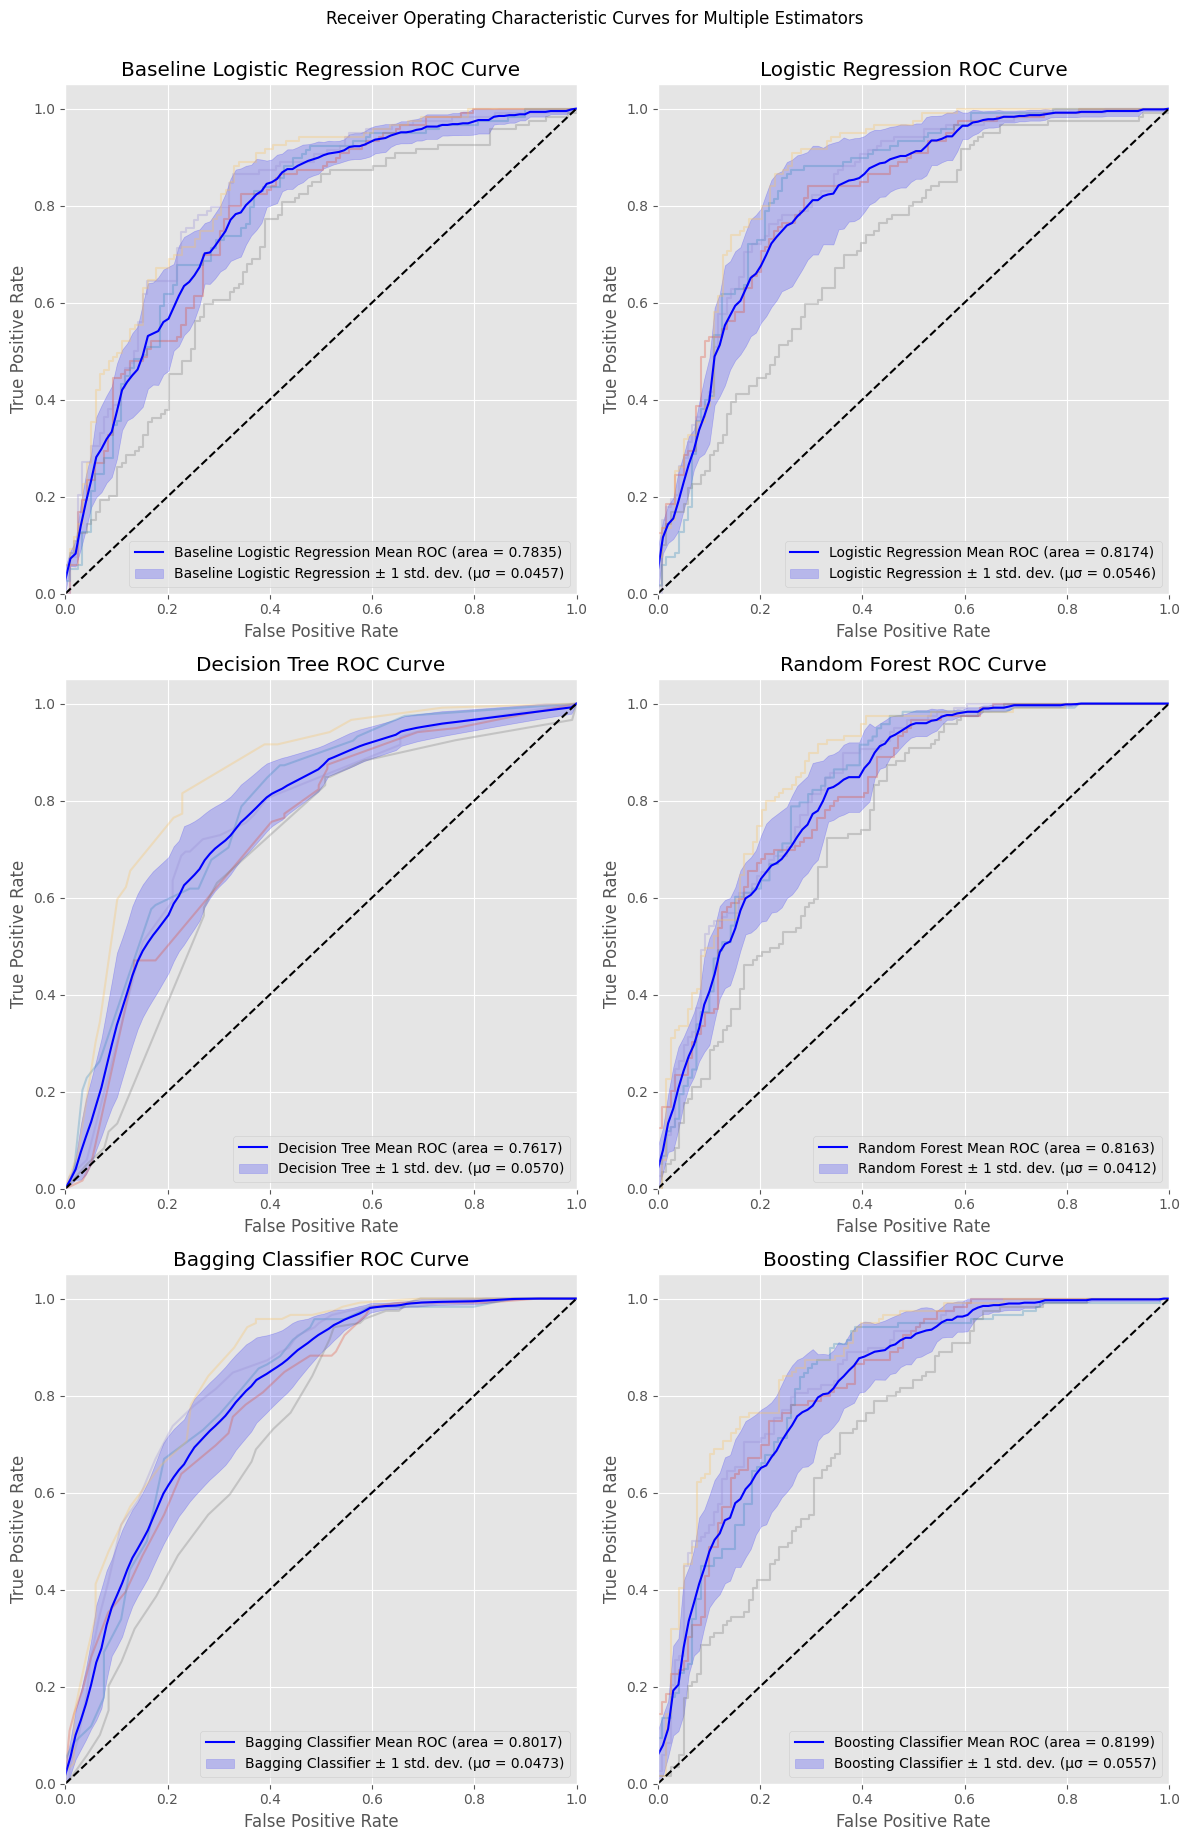

In [71]:
from src.plot_utils import plot_multiple_roc_curves

plot_multiple_roc_curves([base_roc_curves, lr_roc_curves, dt_roc_curves, rf_roc_curves, bg_roc_curves, bt_roc_curves], 
                         ['Baseline Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging Classifier', 'Boosting Classifier'])

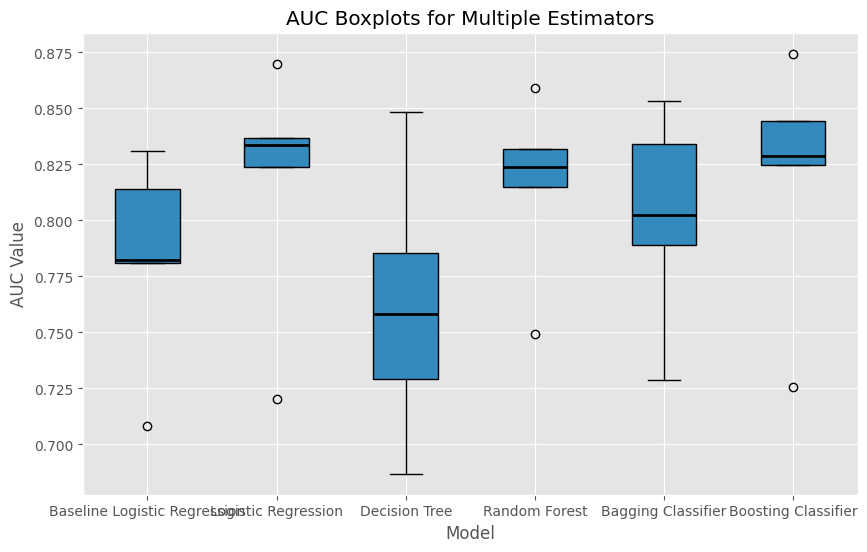

In [72]:
from src.plot_utils import plot_auc_boxplots

plot_auc_boxplots([base_roc_curves, lr_roc_curves, dt_roc_curves, rf_roc_curves, bg_roc_curves, bt_roc_curves], 
                  ['Baseline Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging Classifier', 'Boosting Classifier'])

### Confusion Matrices

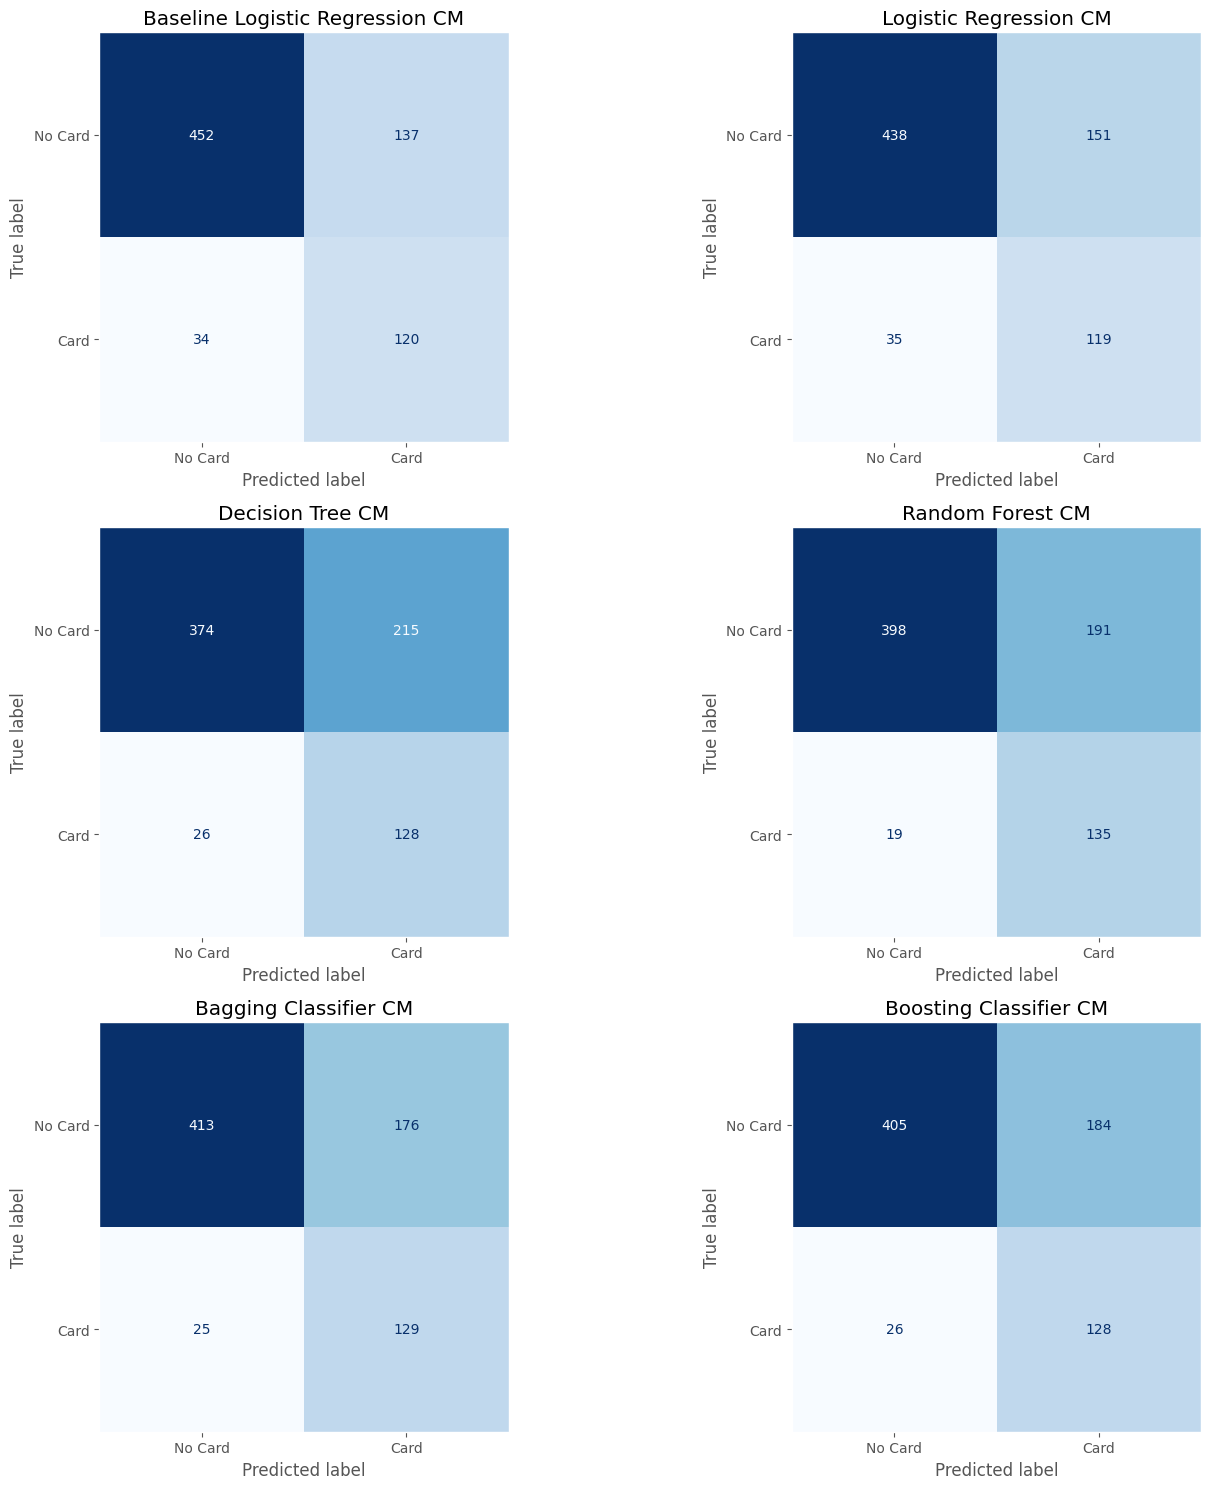

In [73]:
from src.plot_utils import plot_confusion_matrices

plot_confusion_matrices([base_estimator, lr_estimator, dt_estimator, rf_estimator, bg_estimator, bt_estimator], 
                        X_test[all_vars_column_selection.columns], 
                        y_test,
                        ['Baseline Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging Classifier', 'Boosting Classifier'])

### Other Metrics

In [74]:
average_metrics = []

for name, df in zip(['Baseline Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging Classifier', 'Boosting Classifier'], 
                    [base_metrics_df, lr_metrics_df, dt_metrics_df, rf_metrics_df, bg_metrics_df, bt_metrics_df]):
    mean_metrics = df.mean()
    mean_metrics['Estimator'] = name
    average_metrics.append(mean_metrics)

average_metrics_df = pd.DataFrame(average_metrics)[['Estimator', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']]

average_metrics_df

,Estimator,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Baseline Logistic Regression,0.710797,0.711504,0.710797,0.710601,0.783406
1,Logistic Regression,0.753792,0.754372,0.753792,0.753659,0.816792
2,Decision Tree,0.713357,0.716122,0.713357,0.712285,0.761668
3,Random Forest,0.739475,0.746009,0.739475,0.737629,0.815846
4,Bagging Classifier,0.729355,0.732452,0.729355,0.728562,0.801596
5,Boosting Classifier,0.748729,0.749692,0.748729,0.748487,0.819575


## Model Reduction

### Selecting Features

In [96]:
lr_rfe_pipeline = Pipeline([
    ('preprocessor', all_vars_prep_pipeline),
    ('classifier', LogisticRegression(**lr_estimator.named_steps['classifier'].get_params()))
])

(lr_rfe_estimator,
 lr_rfe_params,
 lr_rfe_metrics_df,
 lr_rfe_roc_curves,
 lr_rfe_pr_curves,
 lr_rfe_lift_probs,
 lr_rfe_true_labels) = cross_validate(lr_rfe_pipeline, all_vars_column_selection, y_train, n_features_to_select=20)

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 1063.14it/s]


In [122]:
rfe_step = lr_rfe_estimator.named_steps['rfe']
column_ids = rfe_step.get_support()

rfe_selected_columns = lr_rfe_estimator.named_steps['preprocessor'].get_feature_names_out()[column_ids]

pd.DataFrame(rfe_selected_columns, columns=['Selected Features'])

,Selected Features
0,num__n_transactions_month_diff_1
1,num__n_transactions_month_diff_13
2,num__account_age
3,num__pre_card_volume_mean
4,num__pre_card_credit_mean
5,num__pre_card_n_transactions_mean
6,num__pre_card_n_transactions_sum
7,num__n_transactions_month_min
8,num__n_transactions_month_max
9,num__n_transactions_first_quarter_std


## Model Explanation

In [145]:
from dalex import Explainer

X_train_rfe_prep = lr_rfe_estimator.named_steps['preprocessor'].transform(X_train[all_vars_column_selection.columns])
X_train_rfe_selected_cols = lr_rfe_estimator.named_steps['rfe'].transform(X_train_rfe_prep)

X_train_rfe_selected_cols = X_train_rfe_selected_cols.toarray()

X_train_rfe_selected_cols = pd.DataFrame(X_train_rfe_selected_cols, columns=rfe_selected_columns)

explainer = Explainer(lr_rfe_estimator.named_steps['classifier'], X_train_rfe_selected_cols, y_train, label='Reduced Logistic Regression')

Preparation of a new explainer is initiated

  -> data              : 1186 rows 20 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1186 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Reduced Logistic Regression
  -> predict function  : <function yhat_proba_default at 0x29c6f5e40> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00037, mean = 0.499, max = 0.996
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.982, mean = 0.00129, max = 0.931
  -> model_info        : package sklearn

A new explainer has been created!


In [146]:
explainer.model_performance()

,recall,precision,f1,accuracy,auc
Reduced Logistic Regression,0.789207,0.767213,0.778055,0.774874,0.848505


In [147]:
explainer.model_parts(type='variable_importance').plot()

In [148]:
# plot partial dependence plot
pd_rf = explainer.model_profile()

pd_rf.plot()

Calculating ceteris paribus: 100%|██████████| 20/20 [00:00<00:00, 108.95it/s]


## Top Customer Lists

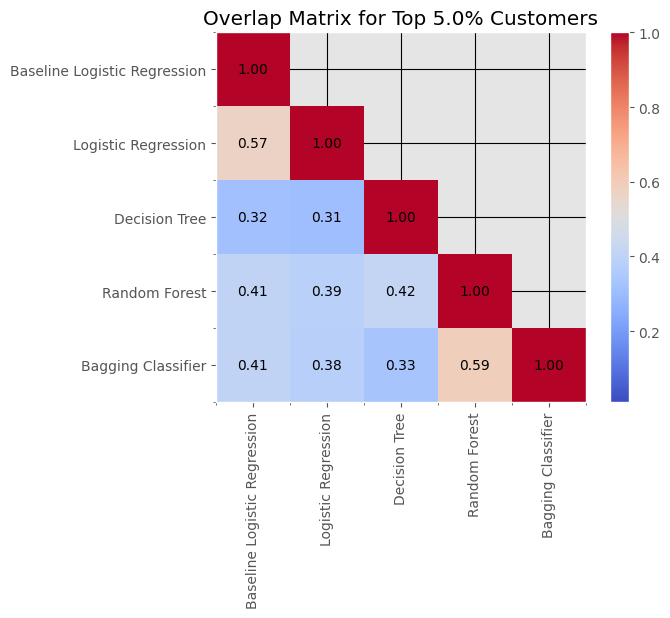

In [149]:
from src.plot_utils import plot_model_concordance

estimators = [base_estimator, lr_estimator, dt_estimator, rf_estimator, bg_estimator]
estimator_names = ['Baseline Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging Classifier']
non_card_holders = cleaned_client_df[cleaned_client_df['has_card'] == False].drop(columns='has_card')

plot_model_concordance(estimators, estimator_names, non_card_holders, p=0.05)

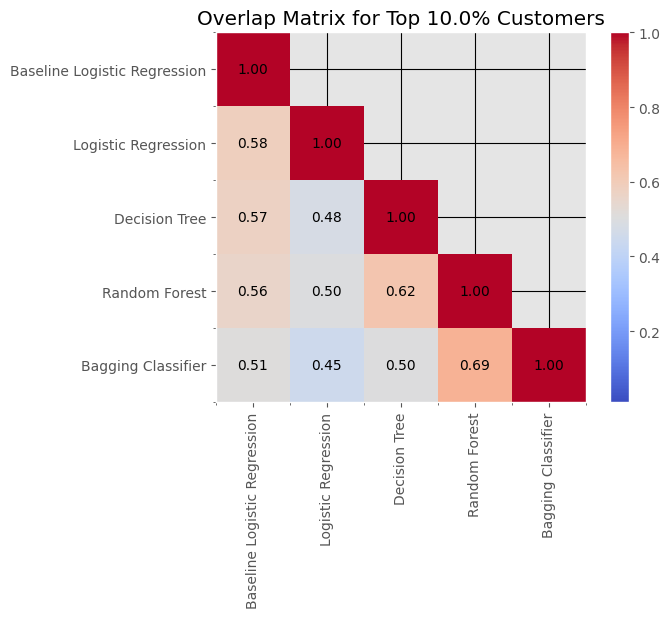

In [150]:
plot_model_concordance(estimators, estimator_names, non_card_holders, p=0.1)